In [65]:
install.packages('ineq')

Installing package into ‘/home/jovyan/.R/lib’
(as ‘lib’ is unspecified)


In [2]:
library(ggthemes)
library(pryr)
library(tidyverse)
library(scater)
library(idcells)
library(matrixStats)
library(ineq)

In [3]:
df_simu_1 <- readRDS("task1_simu.filtered/simu_1.rds")
head(df_simu_1)

gene            barcode            count simulation
1 ensg00000088930 atgcttctactgggtc-1 3     simu_1.gz 
2 ensg00000011485 tgcgtgtgttaagcca-1 4     simu_1.gz 
3 ensg00000083223 acgtcactaagggtgc-1 1     simu_1.gz 
4 ensg00000077097 gatgtttacgctctta-1 2     simu_1.gz 
5 ensg00000174100 cggccacgtgtcatta-1 1     simu_1.gz 
6 ensg00000179085 cgtaggcgtctgaccc-1 2     simu_1.gz

In [4]:
mat_simu_1 <- df2sparse(df_simu_1)
dim(mat_simu_1)
set.seed(101)
mat_simu_1_small <- mat_simu_1[, sample(x = 1:ncol(mat_simu_1), size = 10000)]

[1] 21490 72239

In [5]:
bcstats_simu_1 <- get_barcode_stats(as.matrix(mat_simu_1))
head(bcstats_simu_1)

total_counts mean_counts var_counts genes_detected prop_detected
1 237          0.011028385 0.01891136 187            0.008701722  
2 182          0.008469055 0.01165520 154            0.007166124  
3 225          0.010469986 0.01408368 194            0.009027455  
4 313          0.014564914 0.03008242 228            0.010609586  
5 232          0.010795719 0.01775305 184            0.008562122  
6 271          0.012610517 0.02241065 207            0.009632387

In [6]:
rm(df_simu_1)

In [7]:
mem_used()

542 MB

In [6]:
pd <- as(data.frame(barcode = colnames(mat_simu_1_small)), 
         "AnnotatedDataFrame")
rownames(pd) <- colnames(mat_simu_1_small)
fd <- as(data.frame(gene_id = rownames(mat_simu_1_small)), 
         "AnnotatedDataFrame")
rownames(fd) <- rownames(mat_simu_1_small)
sce <- newSCESet(countData = as.matrix(mat_simu_1_small), phenoData = pd,
                 featureData = fd)
ambient_bool <- read_tsv("ambient_genes.txt", col_names = FALSE)
ambient_sparse <- read_tsv("ambient_genes.sparse.txt", col_names = FALSE)
ambient_gene <- read_tsv("ambient_genes.gene_names.txt", col_names = FALSE)
ambient <- bind_cols(ambient_gene, ambient_bool, ambient_sparse)
table(ambient[[1]] %in% featureNames(sce))
sce <- sce[(featureNames(sce) %in% ambient[[1]]),]
ambient <- ambient[ambient[[1]] %in% featureNames(sce),]
fData(sce)$ambient_gene_l2 <- ambient[[2]]
fData(sce)$ambient_gene_l1 <- ambient[[3]]
sce <- sce[rowSums(counts(sce)) > 0.5,]
sce

Parsed with column specification:
cols(
  X1 = col_logical()
)
Parsed with column specification:
cols(
  X1 = col_logical()
)
Parsed with column specification:
cols(
  X1 = col_character()
)



FALSE  TRUE 
  372 21372 

SCESet (storageMode: lockedEnvironment)
assayData: 17325 features, 10000 samples 
  element names: counts, exprs 
protocolData: none
phenoData
  sampleNames: cgacgtgacaataaat-1 aatgcaacgcggtgct-1 ...
    tgactagtactgtaaa-1 (10000 total)
  varLabels: barcode
  varMetadata: labelDescription
featureData
  featureNames: ensg00000000003 ensg00000000419 ... ensg00000273493
    (17325 total)
  fvarLabels: gene_id ambient_gene_l2 ambient_gene_l1
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'
Annotation:  

In [15]:
sce <- calculateQCMetrics(sce, 
                          feature_controls = list(ambient = fData(sce)$ambient_gene_l1))

In [16]:
saveRDS(sce, "sceset_simu_1.rds")

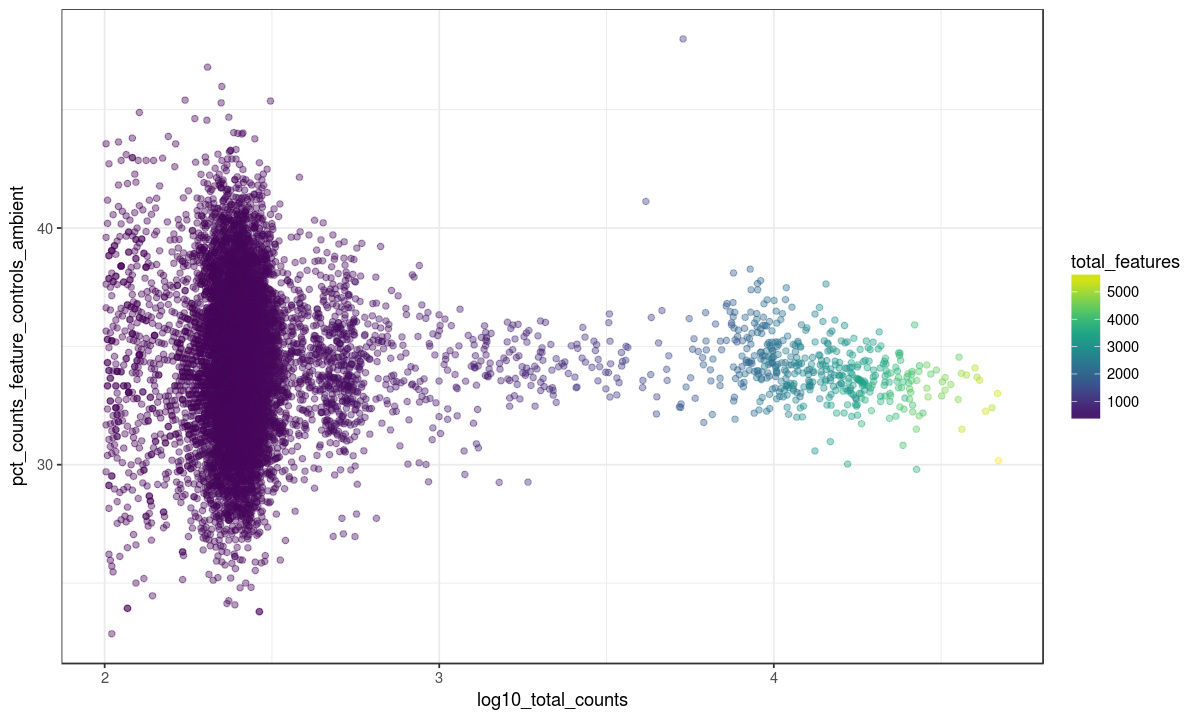

In [14]:
options(repr.plot.width = 10, repr.plot.height=6)
ggplot(pData(sce), aes(x = log10_total_counts, y = pct_counts_feature_controls_ambient, colour = total_features)) +
    geom_point(alpha = 0.4) +
    theme_bw() + viridis::scale_color_viridis()


## Ambient gene analysis

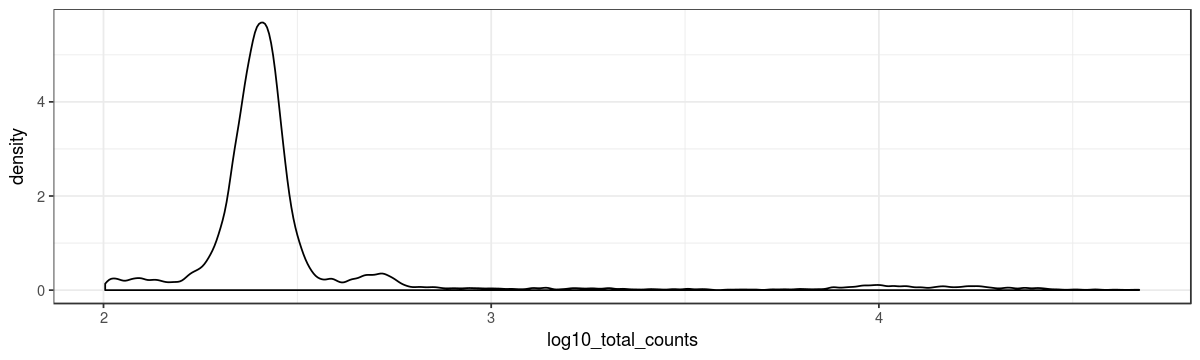

In [19]:
options(repr.plot.width = 10, repr.plot.height=3)
ggplot(pData(sce), aes(x = log10_total_counts)) +
    geom_density(alpha = 0.4) +
    theme_bw() + viridis::scale_color_viridis()

In [18]:
profile_ambient <- function(object, max_umis = 1000) {
    agg_counts <- rowSums(counts(object)[, object$total_counts < max_umis])
    agg_cpm <- agg_counts / sum(agg_counts)
    data_frame(agg_counts, agg_cpm, agg_exprs = log2(agg_cpm + 1))
}

In [39]:
ambient_profile_500 <- profile_ambient(sce, 500)
ambient_profile_1000 <- profile_ambient(sce, 1000)

In [41]:
table(ambient_profile_500[[1]] == 0)


FALSE  TRUE 
14291  3034 

In [42]:
table(ambient_profile_1000[[1]] == 0)


FALSE  TRUE 
14457  2868 

In [43]:
summary(ambient_profile_1000[["agg_cpm"]])

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.000e+00 4.010e-07 4.011e-06 5.772e-05 2.085e-05 1.723e-02 

In [46]:
summary(ambient_profile_500[["agg_cpm"]])

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.000e+00 4.360e-07 3.922e-06 5.772e-05 2.048e-05 1.724e-02 

In [44]:
sum(ambient_profile_500[[1]])

[1] 2294750

In [45]:
sum(ambient_profile_1000[[1]])

[1] 2493353

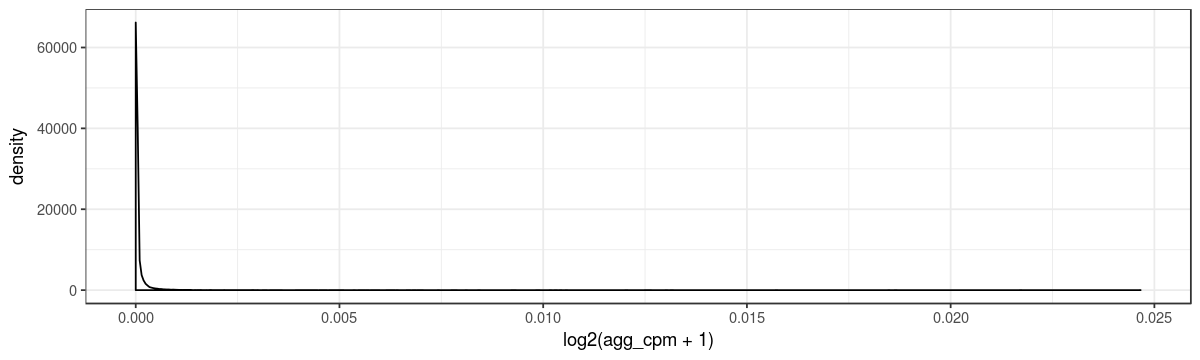

In [47]:
ggplot(ambient_profile_500, aes(x = log2(agg_cpm + 1))) +
    geom_density() + theme_bw()

In [48]:
sce_agg_amb <- sce

In [49]:
sce_agg_amb <- calculateQCMetrics(sce_agg_amb, 
                          feature_controls = list(
                              ambient = ambient_profile_500[[2]] > median(ambient_profile_500[[2]])))

In [56]:
meanvar_df <- data_frame(mean_exprs = rowMeans(exprs(sce)), var_exprs = rowVars(exprs(sce)))

`geom_smooth()` using method = 'gam'


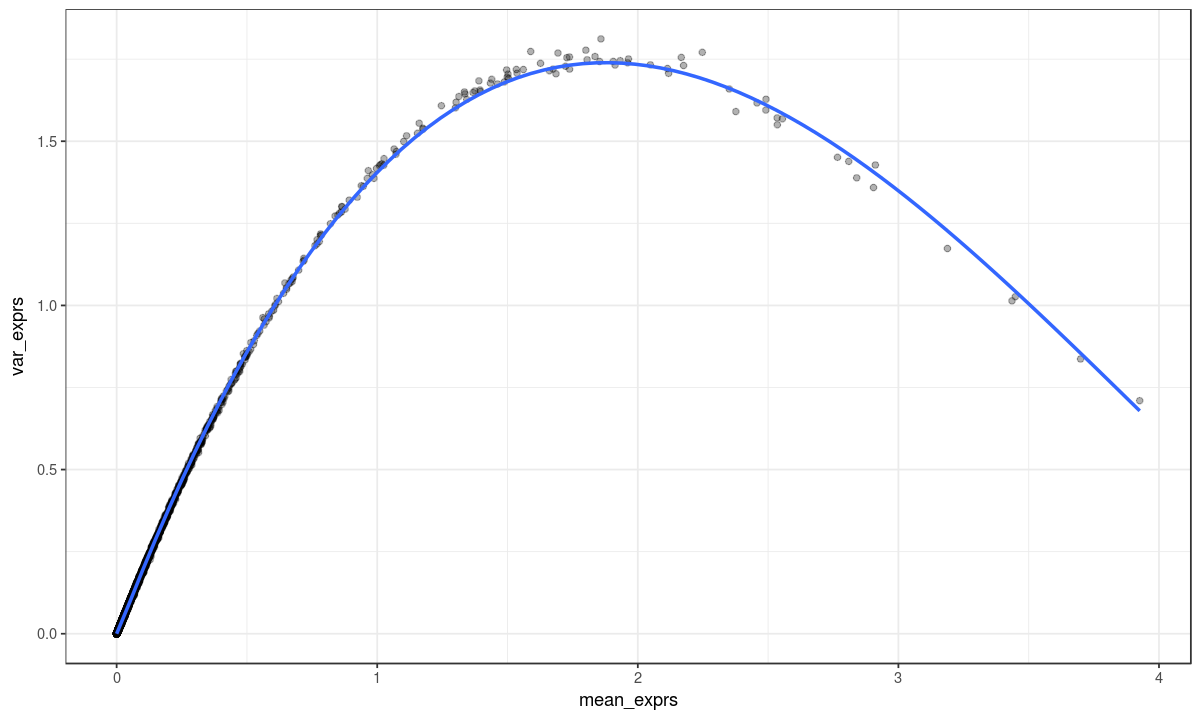

In [57]:
ggplot(meanvar_df, aes(x = mean_exprs, y = var_exprs)) +
    geom_point(alpha = 0.3) + geom_smooth() +
    theme_bw()

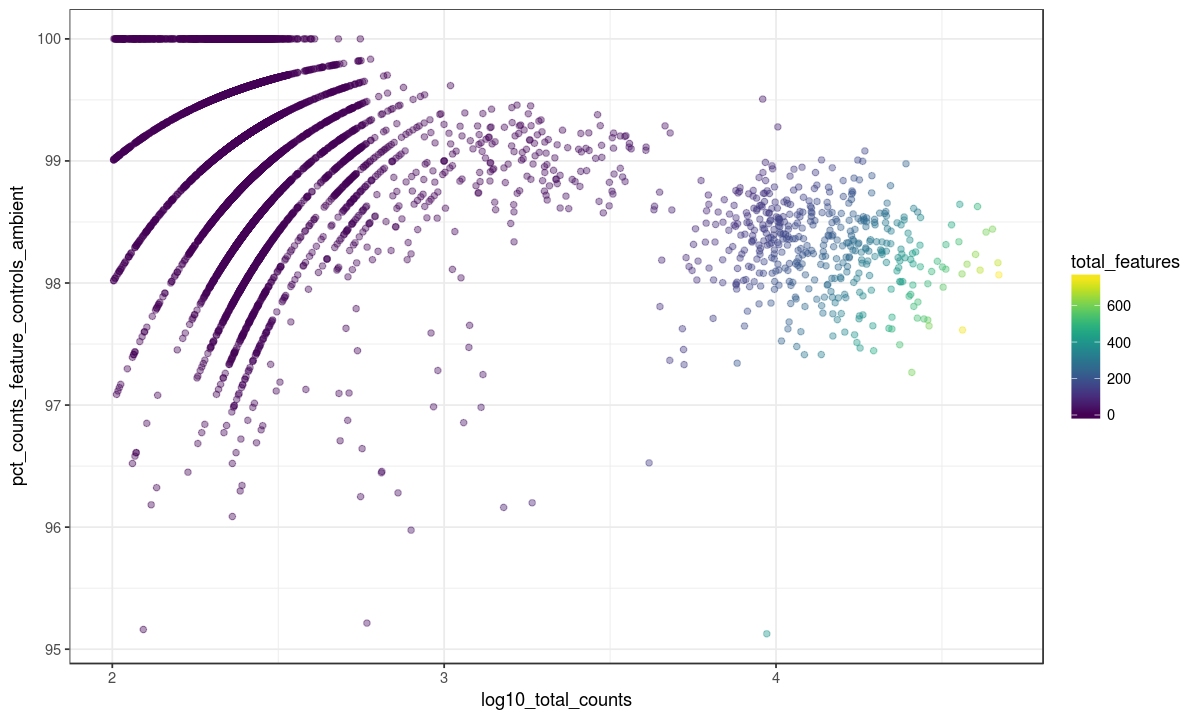

In [50]:
options(repr.plot.width = 10, repr.plot.height=6)
ggplot(pData(sce_agg_amb), aes(x = log10_total_counts, y = pct_counts_feature_controls_ambient, 
                               colour = total_features)) +
    geom_point(alpha = 0.4) +
    theme_bw() + viridis::scale_color_viridis()

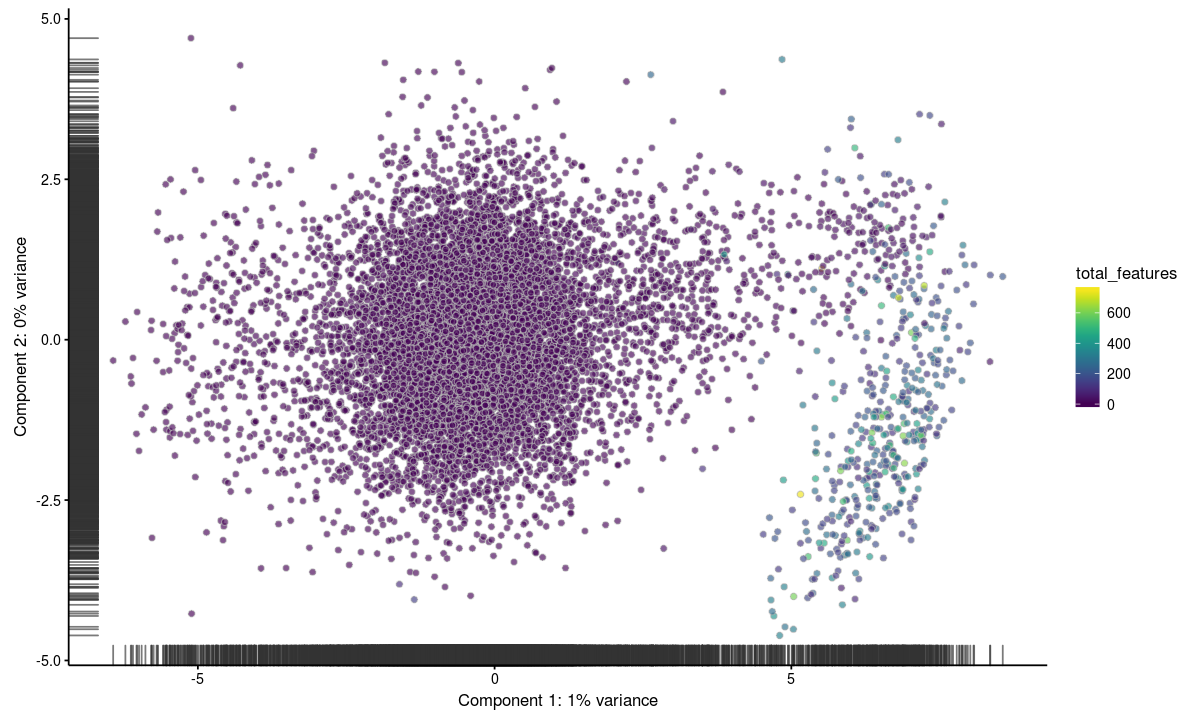

In [51]:
options(repr.plot.width = 10, repr.plot.height=6)
plotPCA(sce_agg_amb[fData(sce_agg_amb)$is_feature_control_ambient,], colour = "total_features")

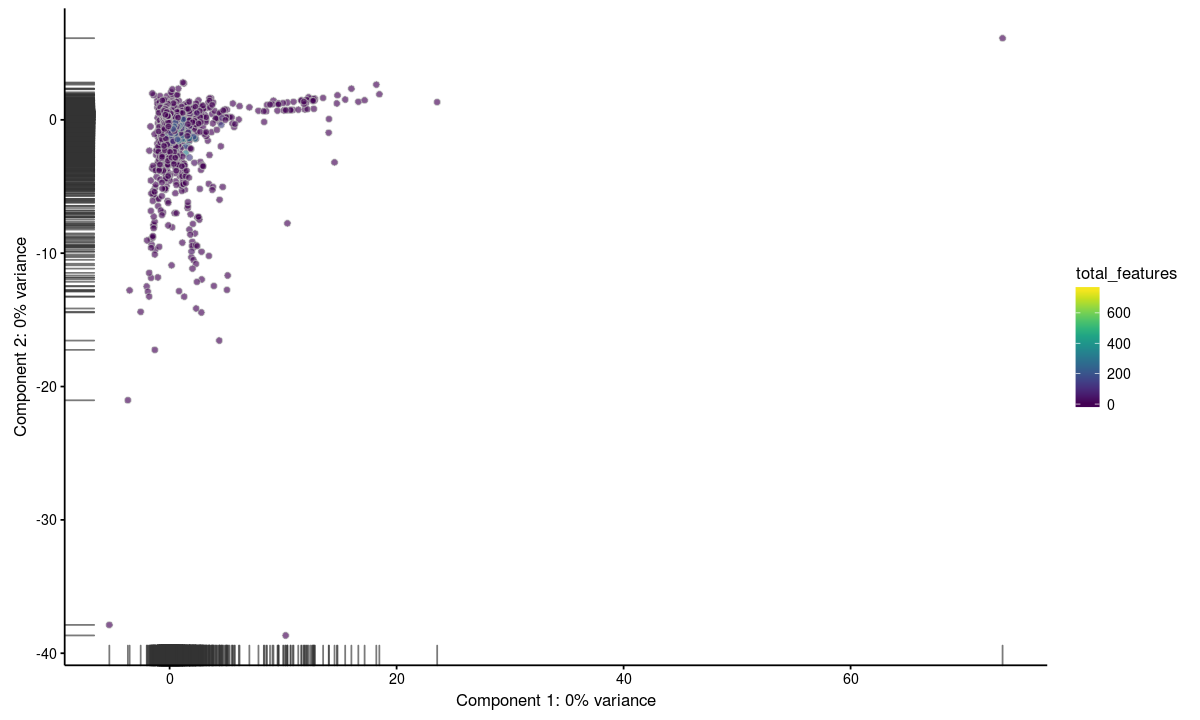

In [52]:
options(repr.plot.width = 10, repr.plot.height=6)
plotPCA(sce_agg_amb[!fData(sce_agg_amb)$is_feature_control_ambient,], colour = "total_features")

In [53]:
summary(colSums(counts(sce_agg_amb)[fData(sce_agg_amb)$is_feature_control_ambient,]))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   99.0   227.0   254.0   911.9   284.0 46012.0 

In [54]:
summary(colSums(counts(sce_agg_amb)[!fData(sce_agg_amb)$is_feature_control_ambient,]))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    1.00    2.00   13.69    4.00  907.00 

In [67]:
sce$gini_all_genes <- apply(exprs(sce), 2, Gini)
ubiq_genes <- featureNames(sce)[fData(sce)$n_cells_exprs > 2500]
nonubiq_genes <- featureNames(sce)[fData(sce)$n_cells_exprs < 2500]
sce$gini_ubiq_genes <- apply(exprs(sce)[ubiq_genes,], 2, Gini)
sce$gini_nonubiq_genes <- apply(exprs(sce)[nonubiq_genes,], 2, Gini)
sce$gini_ambient_genes_l1 <- apply(exprs(sce)[fData(sce)$ambient_gene_l1,], 2, Gini)
sce$gini_ambient_genes_l2 <- apply(exprs(sce)[fData(sce)$ambient_gene_l2,], 2, Gini)

## Covariance/distance analysis

In [ ]:
sce_1000 <- sce[fData(sce)$ambient_gene_l1, 1:1000]
d1 <- dist(as.matrix(t(exprs(sce_1000))))
mds1 <- cmdscale(d1, k = 3)
redDim(sce_1000) <- mds1
plotReducedDim(sce_1000, colour_by = "total_features")

In [ ]:
d2 <- dist(as.matrix(t(exprs(sce_1000))), method = "canberra")
mds2 <- cmdscale(d2, k = 3)
redDim(sce_1000) <- mds2
plotReducedDim(sce_1000, colour_by = "total_features")

In [ ]:
d3 <- dist(as.matrix(t(exprs(sce_1000))), method = "binary")
mds3 <- cmdscale(d3, k = 3)
redDim(sce_1000) <- mds3
plotReducedDim(sce_1000, colour_by = "total_features")

In [ ]:
sce_good <- sce[, sce$total_features > 1000 & sce$total_counts > 2000]
sce_bad <- sce[, sce$total_features < 1000 | sce$total_counts < 2000]
bad_profile_exprs <- matrixStats::rowMedians(exprs(sce_bad))
bad_profile_counts <- matrixStats::rowMedians(counts(sce_bad))

In [58]:
score1 <- cor(exprs(sce), log2(ambient_profile_500[[2]] + 1), method = "pearson")
score2 <- cor(exprs(sce), log2(ambient_profile_500[[2]] + 1), method = "spearman")


In [60]:
sce$bad_score_exprs_pears <- score1[, 1]
sce$bad_score_exprs_spear <- score2[, 1]

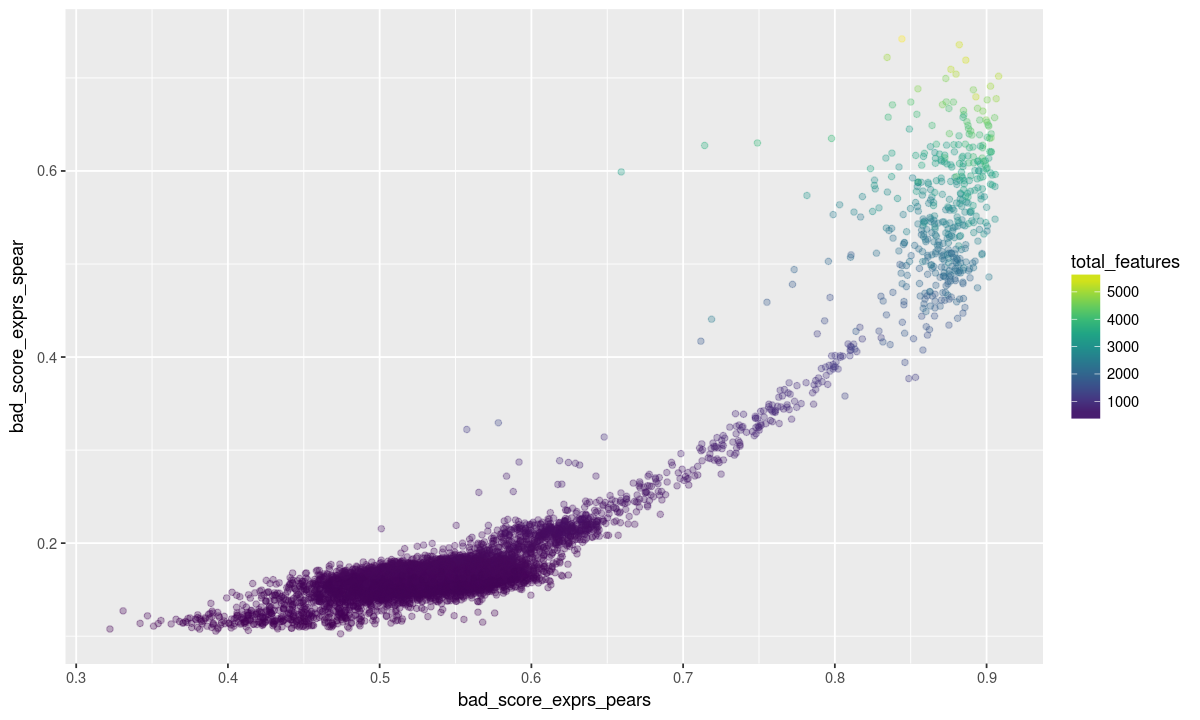

In [62]:
ggplot(pData(sce), aes(x = bad_score_exprs_pears, y = bad_score_exprs_spear, colour = total_features)) +
    geom_point(alpha = 0.3) + viridis::scale_color_viridis()

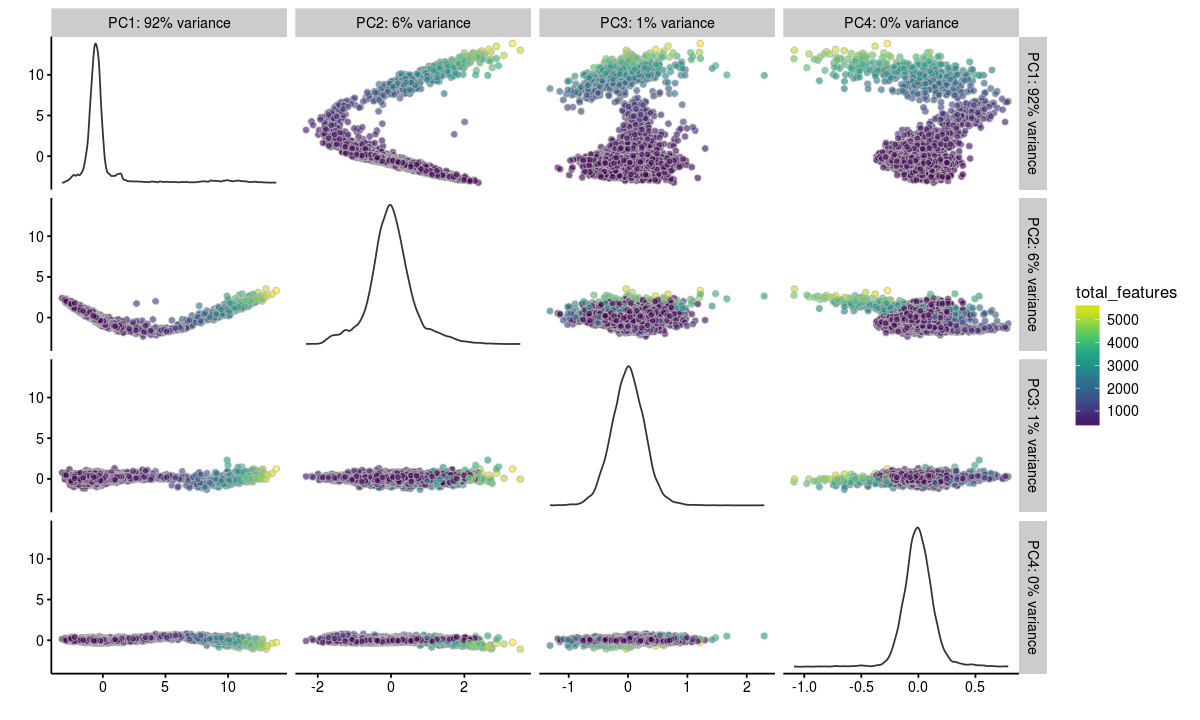

In [71]:
plotPCA(sce, ntop = 500, ncomponents = 4, colour_by = "total_features",
  exprs_values = "exprs", pca_data_input = "pdata",
  selected_variables = c("bad_score_exprs_pears", "bad_score_exprs_spear", 
                         "gini_ubiq_genes", "gini_nonubiq_genes", "gini_ambient_genes_l1", "gini_ambient_genes_l2"))

In [72]:
metrics_pca <- prcomp(pData(sce)[, c("bad_score_exprs_pears", "bad_score_exprs_spear", 
                         "gini_ubiq_genes", "gini_nonubiq_genes", "gini_ambient_genes_l1", "gini_ambient_genes_l2")])

In [74]:
metrics_pca$rotation

PC1        PC2        PC3         PC4        
bad_score_exprs_pears  0.5315044 -0.0483436 -0.84460976  0.04172732
bad_score_exprs_spear  0.5297232  0.5357279  0.28333357 -0.37212612
gini_ubiq_genes       -0.5406153  0.7428806 -0.37823343  0.09248829
gini_nonubiq_genes    -0.1432222 -0.2298833 -0.06037228  0.24874441
gini_ambient_genes_l1 -0.3098831 -0.2352089 -0.22436519 -0.88474472
gini_ambient_genes_l2 -0.1676048 -0.2249830 -0.09649536  0.08111654
                      PC5          PC6         
bad_score_exprs_pears -0.002593595  0.007236887
bad_score_exprs_spear  0.459304024  0.051700916
gini_ubiq_genes        0.063724496  0.013717068
gini_nonubiq_genes     0.591613849  0.714923441
gini_ambient_genes_l1  0.040041351  0.118037955
gini_ambient_genes_l2  0.658302377 -0.687050216

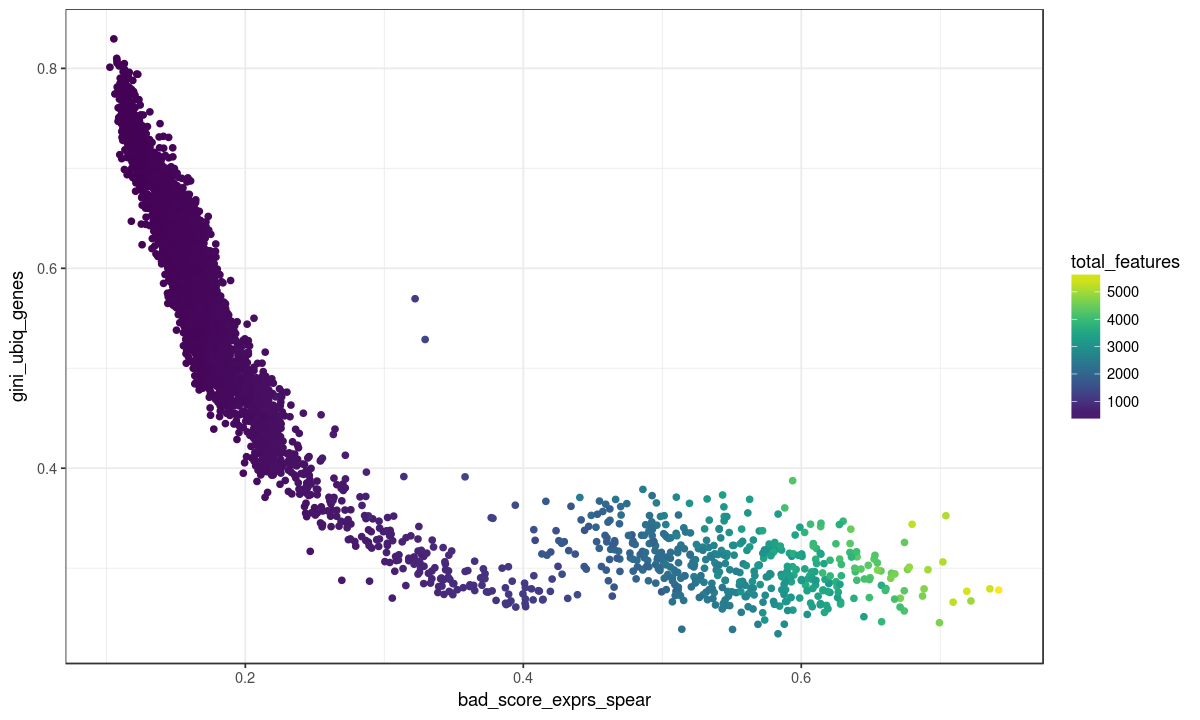

In [77]:
ggplot(pData(sce), aes(x = bad_score_exprs_spear, y = gini_ubiq_genes, colour = total_features)) +
    geom_point() + theme_bw() + viridis::scale_color_viridis()

## Truth

In [8]:
truth_1 <- read_csv("truth/ssimu/real_1")
head(truth_1)

Parsed with column specification:
cols(
  barc = col_character(),
  mode = col_integer()
)


barc               mode
1 gggccatgtccggcgt-1 1   
2 gggccatgtcaagact-1 1   
3 gggccatgtacacggc-1 1   
4 gggccatgtatggcga-1 1   
5 gggccatgtaatgtga-1 1   
6 gggccatcgcttctaa-1 1

In [10]:
pd <- as(data.frame(barcode = colnames(mat_simu_1)), 
         "AnnotatedDataFrame")
rownames(pd) <- colnames(mat_simu_1)
fd <- as(data.frame(gene_id = rownames(mat_simu_1)), 
         "AnnotatedDataFrame")
rownames(fd) <- rownames(mat_simu_1)
keep_gene <- rowSums(as.matrix(mat_simu_1)) > 0.5
sce_train <- newSCESet(countData = as.matrix(mat_simu_1)[keep_gene,], phenoData = pd,
                 featureData = fd[keep_gene,])
sce_train

SCESet (storageMode: lockedEnvironment)
assayData: 21490 features, 72239 samples 
  element names: counts, exprs 
protocolData: none
phenoData
  sampleNames: aaaccacacaacggca-1 aaaccacacagatatt-1 ...
    tttgtgatatttagat-1 (72239 total)
  varLabels: barcode
  varMetadata: labelDescription
featureData
  featureNames: ensg00000000003 ensg00000000005 ... ensg00000273493
    (21490 total)
  fvarLabels: gene_id
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'
Annotation:  

In [11]:
sce_train$truth <- 0

In [12]:
sum(colnames(sce_train) %in% dplyr::filter(truth_1, mode == 1)[[1]])

[1] 3285

In [13]:
sum(colnames(sce_train) %in% dplyr::filter(truth_1, mode == 2)[[1]])

[1] 205

In [14]:
sce_train$truth[colnames(sce_train) %in% dplyr::filter(truth_1, mode == 1)[[1]]] <- 1

In [15]:
sce_train$truth[colnames(sce_train) %in% dplyr::filter(truth_1, mode == 2)[[1]]] <- 2

In [16]:
sce_train$truth <- as.factor(sce_train$truth)

In [17]:
sce_train <- calculateQCMetrics(sce_train)

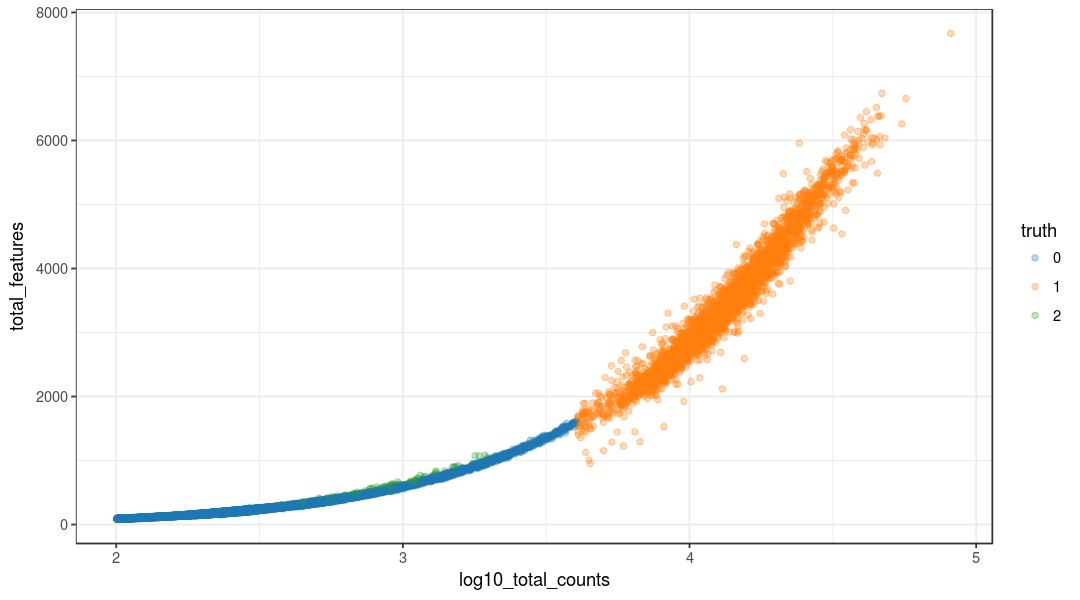

In [18]:
options(repr.plot.width = 9, repr.plot.height = 5)
ggplot(pData(sce_train), aes(x = log10_total_counts, y = total_features, colour = truth)) +
    geom_point(alpha = 0.3) + scale_colour_tableau() + theme_bw()

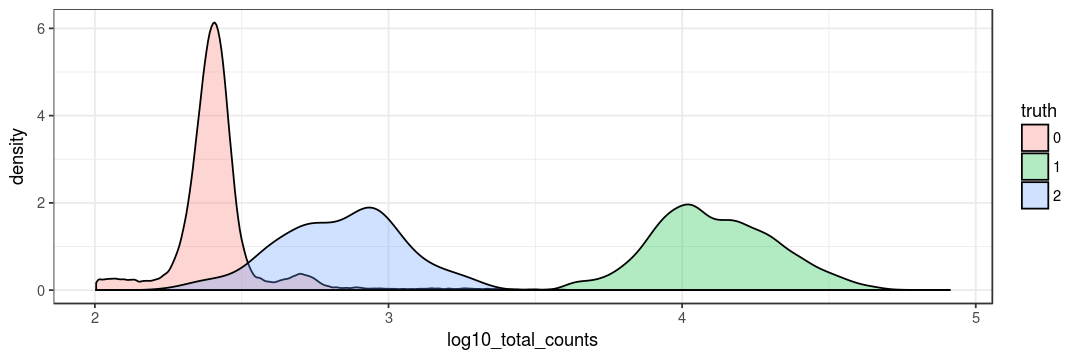

In [19]:
options(repr.plot.width = 9, repr.plot.height = 3)
ggplot(pData(sce_train), aes(x = log10_total_counts, fill = truth)) +
    geom_density(alpha = 0.3) + scale_colour_tableau() + theme_bw()

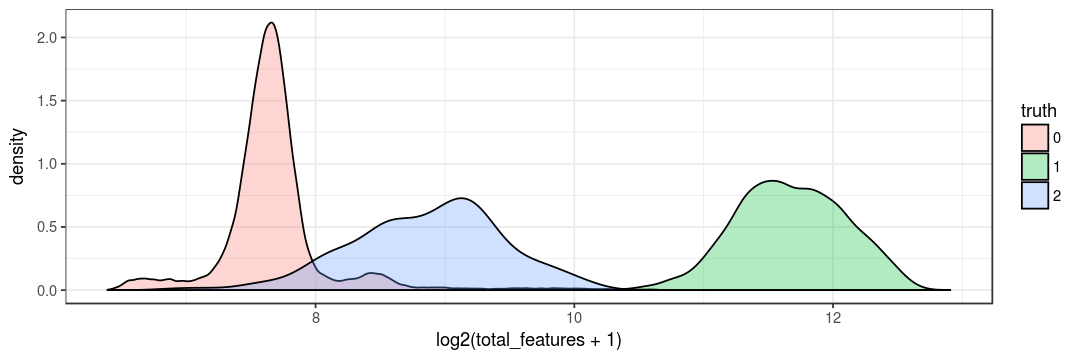

In [20]:
options(repr.plot.width = 9, repr.plot.height = 3)
ggplot(pData(sce_train), aes(x = log2(total_features + 1), fill = truth)) +
    geom_density(alpha = 0.3) + scale_colour_tableau() + theme_bw()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


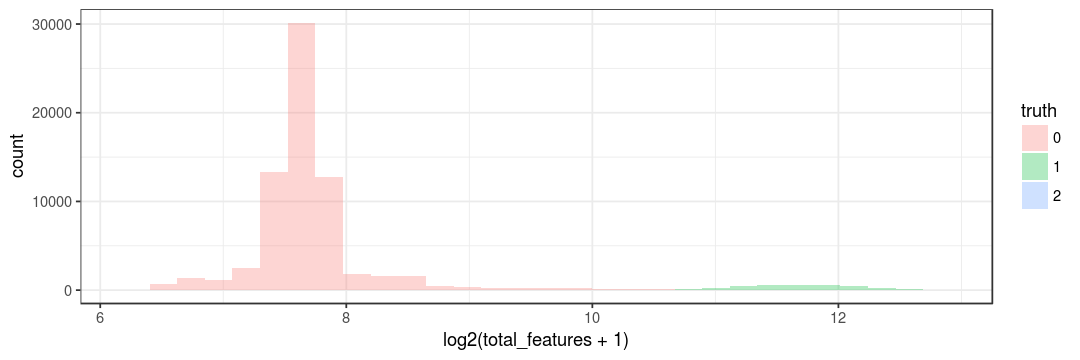

In [21]:
options(repr.plot.width = 9, repr.plot.height = 3)
ggplot(pData(sce_train), aes(x = log2(total_features + 1), fill = truth)) +
    geom_histogram(alpha = 0.3) + scale_colour_tableau() + theme_bw()

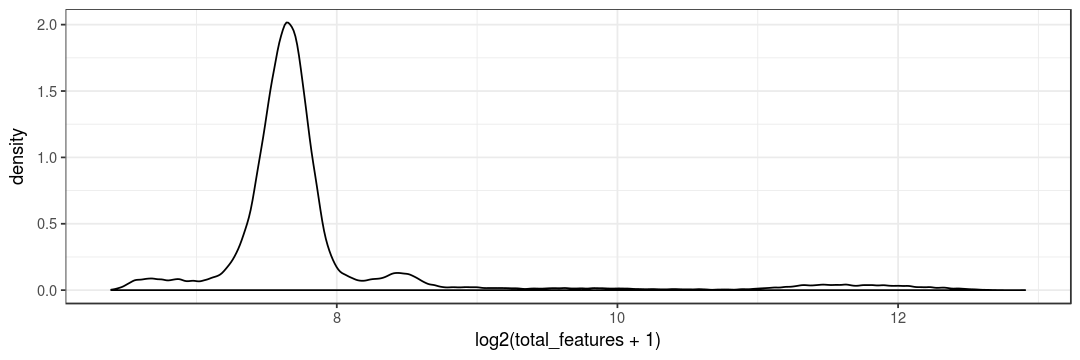

In [22]:
options(repr.plot.width = 9, repr.plot.height = 3)
ggplot(pData(sce_train), aes(x = log2(total_features + 1))) +
    geom_density(alpha = 0.3) + scale_colour_tableau() + theme_bw()

In [23]:
sce_train$gini_all_genes <- apply(exprs(sce_train), 2, Gini)
ubiq_genes <- featureNames(sce_train)[fData(sce_train)$n_cells_exprs > 0.25 * ncol(sce_train)]
nonubiq_genes <- featureNames(sce_train)[fData(sce_train)$n_cells_exprs < 0.25 * ncol(sce_train)]
sce_train$gini_ubiq_genes <- apply(exprs(sce_train)[ubiq_genes,], 2, Gini)
sce_train$gini_nonubiq_genes <- apply(exprs(sce_train)[nonubiq_genes,], 2, Gini)

In [24]:
saveRDS(sce_train, "sceset_train_simu_1.rds")

In [2]:
library(ggthemes)
library(pryr)
library(tidyverse)
library(scater)
library(idcells)
library(matrixStats)
library(ineq)

In [2]:
sce_train <- readRDS("sceset_train_simu_1.rds")

In [3]:
mem_used()

25 GB

In [4]:
#plotPCA(sce_train, colour_by = "truth")

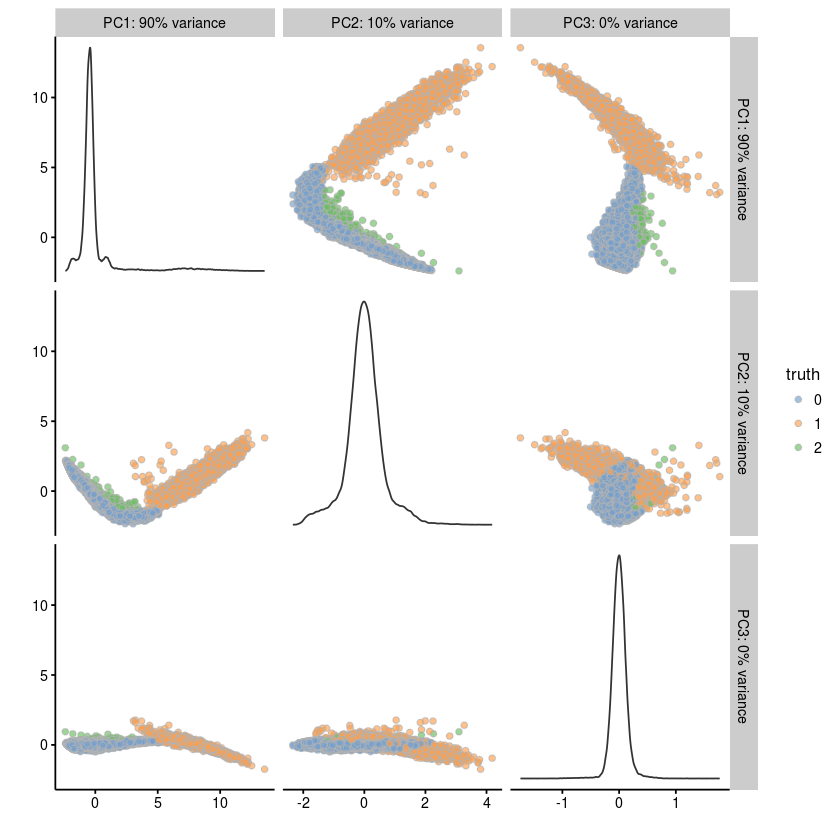

In [6]:
plotPCA(sce_train,  ncomponents = 3,
  colour_by = "truth", pca_data_input = "pdata",
  selected_variables = c("log10_total_counts", "total_features", "gini_nonubiq_genes", "gini_ubiq_genes"))

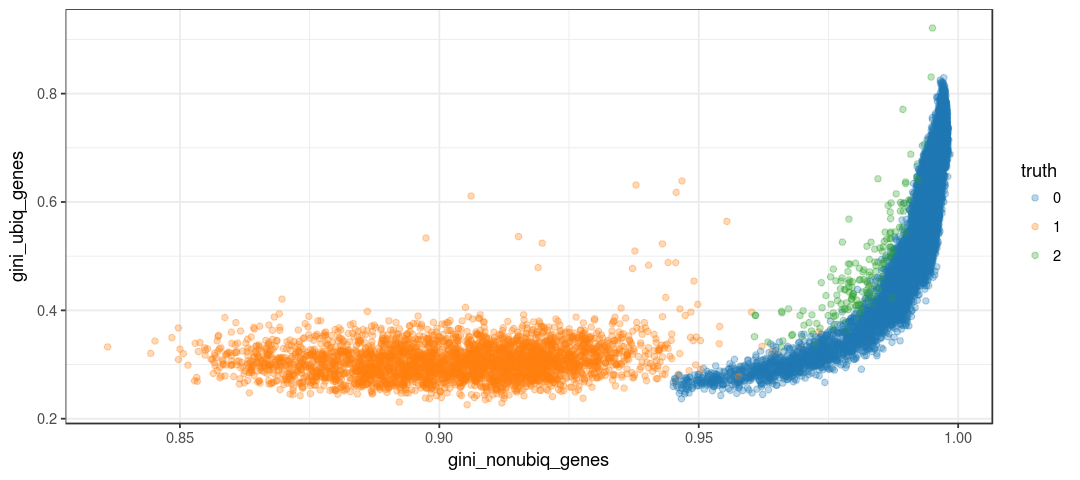

In [8]:
options(repr.plot.width=9, repr.plot.height=4)
ggplot(pData(sce_train), aes(x = gini_nonubiq_genes, y = gini_ubiq_genes, colour = truth)) +
    geom_point(alpha = 0.3) + scale_color_tableau() + theme_bw()

In [9]:
varLabels(sce_train)

[1] "barcode"                               
 [2] "truth"                                 
 [3] "total_counts"                          
 [4] "log10_total_counts"                    
 [5] "filter_on_total_counts"                
 [6] "total_features"                        
 [7] "log10_total_features"                  
 [8] "filter_on_total_features"              
 [9] "pct_dropout"                           
[10] "n_detected_feature_controls"           
[11] "counts_feature_controls"               
[12] "pct_counts_feature_controls"           
[13] "filter_on_pct_counts_feature_controls" 
[14] "pct_counts_top_50_features"            
[15] "pct_counts_top_100_features"           
[16] "pct_counts_top_200_features"           
[17] "pct_counts_top_500_features"           
[18] "pct_counts_top_50_endogenous_features" 
[19] "pct_counts_top_100_endogenous_features"
[20] "pct_counts_top_200_endogenous_features"
[21] "pct_counts_top_500_endogenous_features"
[22] "counts_endogenous_features"            
[23] "log10_counts_feature_controls"         
[24] "log10_counts_endogenous_features"      
[25] "is_cell_control"                       
[26] "gini_all_genes"                        
[27] "gini_ubiq_genes"                       
[28] "gini_nonubiq_genes"

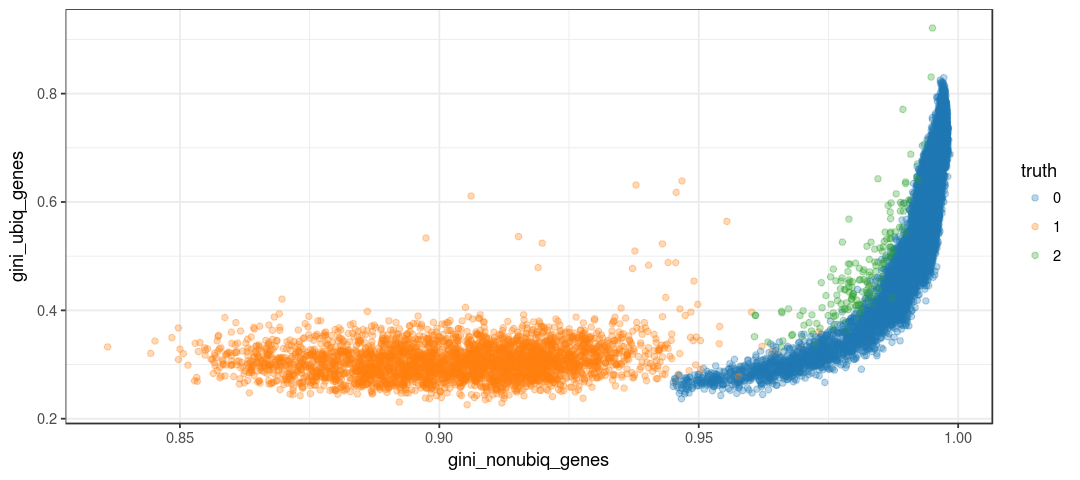

In [10]:
ggplot(pData(sce_train), aes(x = gini_nonubiq_genes, y = gini_ubiq_genes, colour = truth)) +
    geom_point(alpha = 0.3) + scale_color_tableau() + theme_bw()

In [3]:
library(mclust)

Package 'mclust' version 5.3
Type 'citation("mclust")' for citing this R package in publications.

Attaching package: ‘mclust’

The following object is masked from ‘package:purrr’:

    map



In [6]:
sce_train_small <- sce_train[, sce_train$total_counts > 500]

In [20]:
profile_ambient <- function(object, max_umis = 1000) {
    agg_counts <- rowSums(counts(object)[, object$total_counts < max_umis])
    agg_cpm <- agg_counts / sum(agg_counts)
    data_frame(agg_counts, agg_cpm, agg_exprs = log2(agg_cpm + 1))
}

In [8]:
ambient_profile_500 <- profile_ambient(sce_train, 500)

In [9]:
dim(sce_train_small)

Features  Samples 
   21490     6747

In [13]:
sce_train_small$ambient_cor_spear <- cor(exprs(sce_train_small), ambient_profile_500[[3]], method = "spearman")

In [12]:
sce_train_small$log10_total_features <- log10(sce_train_small$total_features)

In [11]:
saveRDS(sce_train_small, "sceset_train_small_simu_1.rds")

In [4]:
sce_train_small <- readRDS("sceset_train_small_simu_1.rds")

In [6]:
mc <- Mclust(pData(sce_train_small)[, c("log10_total_counts")])

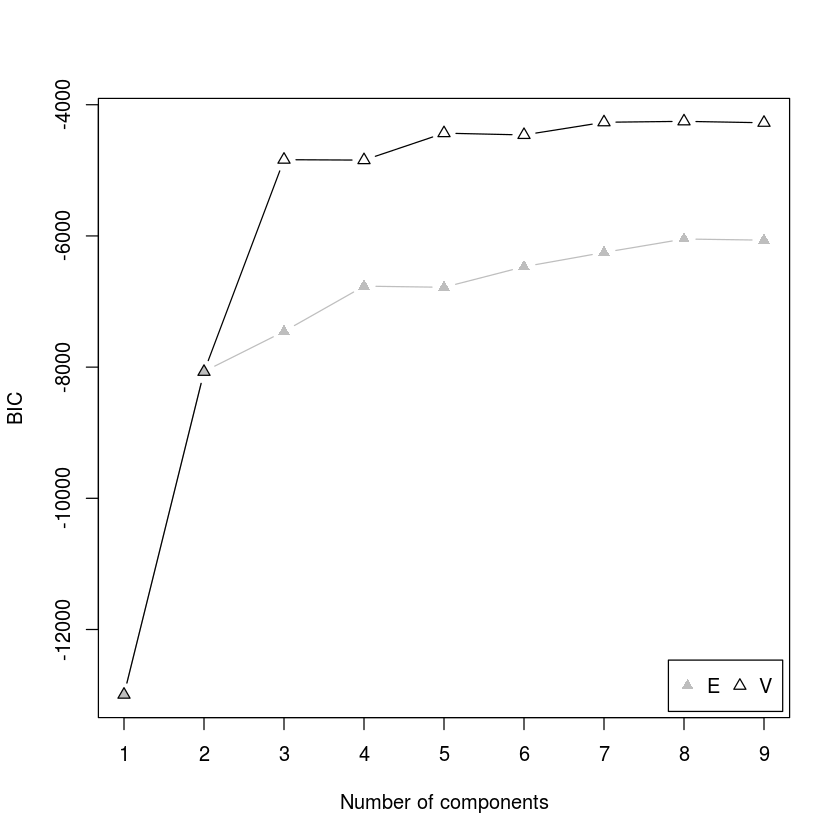

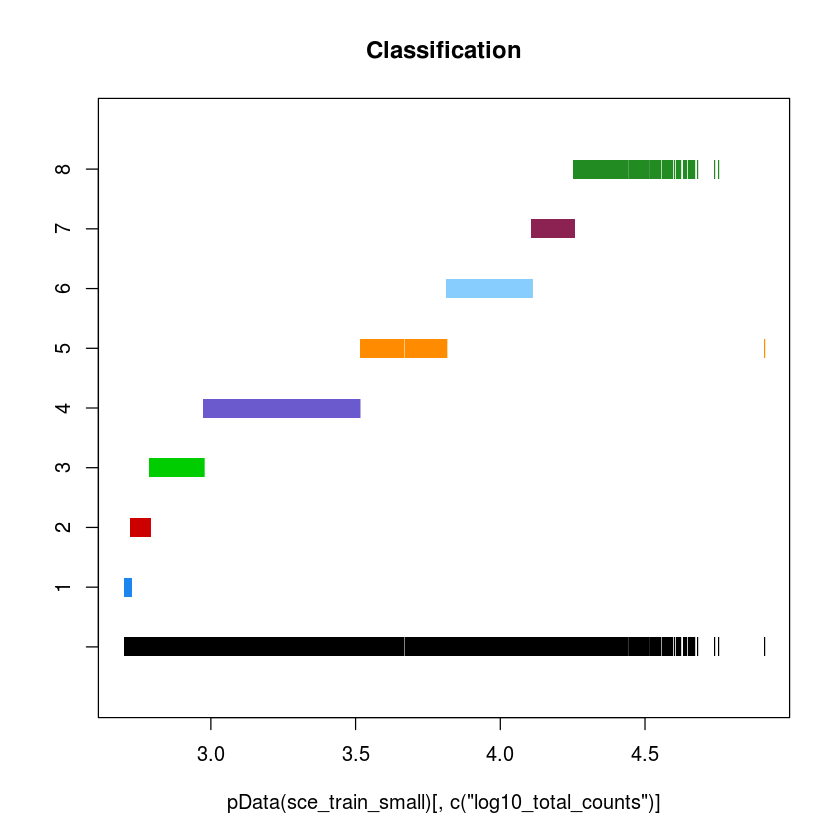

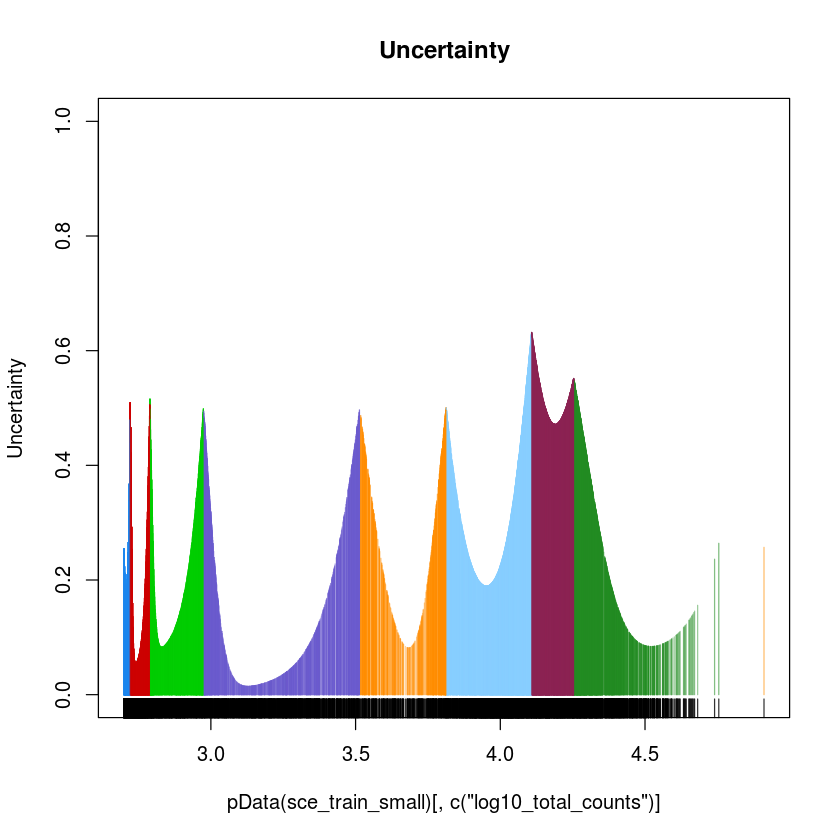

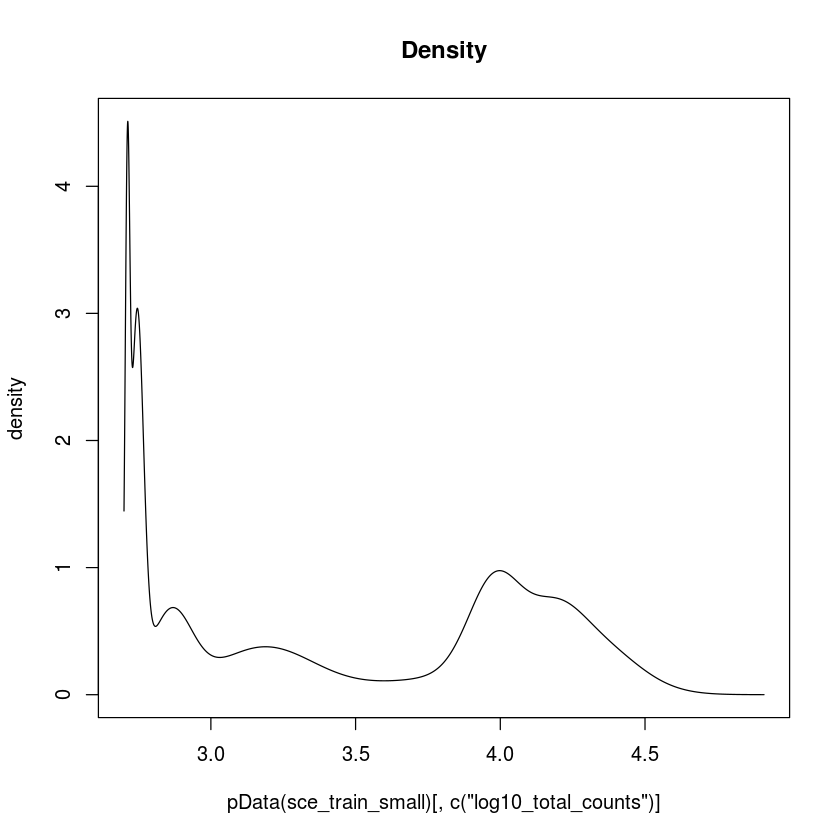

In [7]:
plot(mc)

In [8]:
 mc

'Mclust' model object:
 best model: univariate, unequal variance (V) with 8 components

In [13]:
sce_train_small$mclust_umis_class <- as.factor(mc$classification)

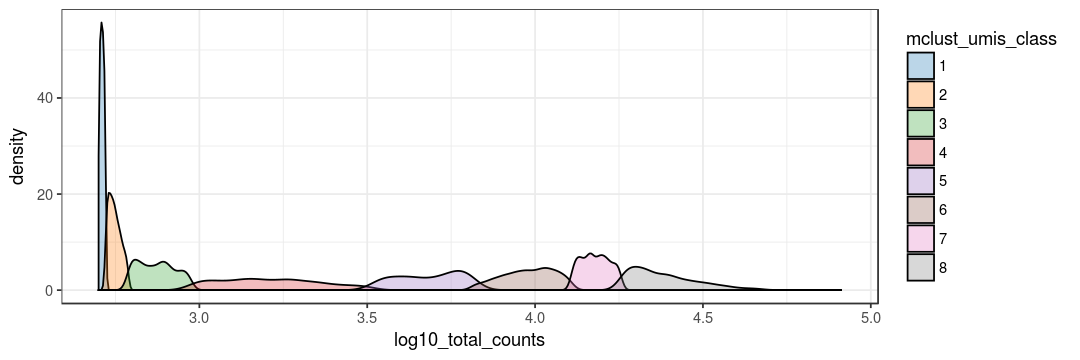

In [16]:
options(repr.plot.width = 9, repr.plot.height = 3)
ggplot(pData(sce_train_small), aes(x = log10_total_counts, fill = mclust_umis_class)) +
    geom_density(alpha = 0.3) + scale_fill_tableau() + theme_bw()

In [17]:
library(ggjoy)

Picking joint bandwidth of 0.0158


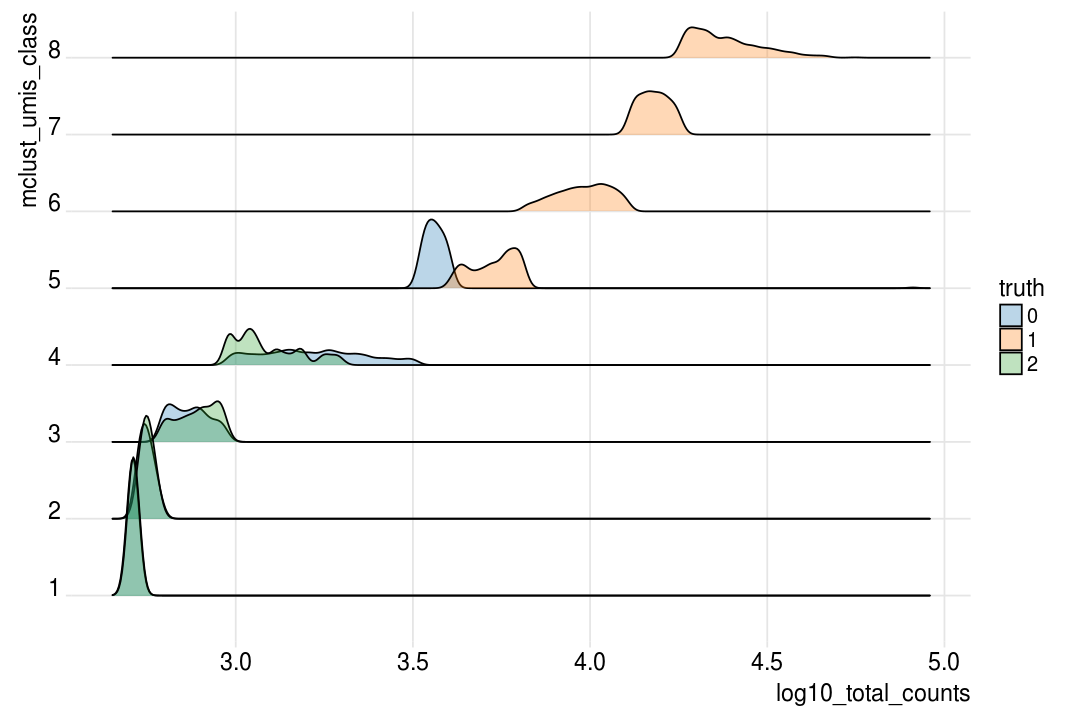

In [18]:
options(repr.plot.width = 9, repr.plot.height = 6)
ggplot(pData(sce_train_small), aes(x = log10_total_counts, y = mclust_umis_class, fill = truth)) +
    geom_joy(alpha = 0.3) + scale_fill_tableau() + theme_joy()

In [19]:
varLabels(sce_train_small)

[1] "barcode"                               
 [2] "truth"                                 
 [3] "total_counts"                          
 [4] "log10_total_counts"                    
 [5] "filter_on_total_counts"                
 [6] "total_features"                        
 [7] "log10_total_features"                  
 [8] "filter_on_total_features"              
 [9] "pct_dropout"                           
[10] "n_detected_feature_controls"           
[11] "counts_feature_controls"               
[12] "pct_counts_feature_controls"           
[13] "filter_on_pct_counts_feature_controls" 
[14] "pct_counts_top_50_features"            
[15] "pct_counts_top_100_features"           
[16] "pct_counts_top_200_features"           
[17] "pct_counts_top_500_features"           
[18] "pct_counts_top_50_endogenous_features" 
[19] "pct_counts_top_100_endogenous_features"
[20] "pct_counts_top_200_endogenous_features"
[21] "pct_counts_top_500_endogenous_features"
[22] "counts_endogenous_features"            
[23] "log10_counts_feature_controls"         
[24] "log10_counts_endogenous_features"      
[25] "is_cell_control"                       
[26] "gini_all_genes"                        
[27] "gini_ubiq_genes"                       
[28] "gini_nonubiq_genes"                    
[29] "mclust_umis_class"

In [22]:
ambient_profile_1000 <- profile_ambient(sce_train_small, 1000)

In [23]:
sce_train_small$ambient_cor_spear <- cor(exprs(sce_train_small), ambient_profile_1000[[3]], method = "spearman")

In [24]:
mc2 <- Mclust(pData(sce_train_small)[, c("log10_total_counts", "log10_total_features", 
                                         "gini_nonubiq_genes", "ambient_cor_spear")])

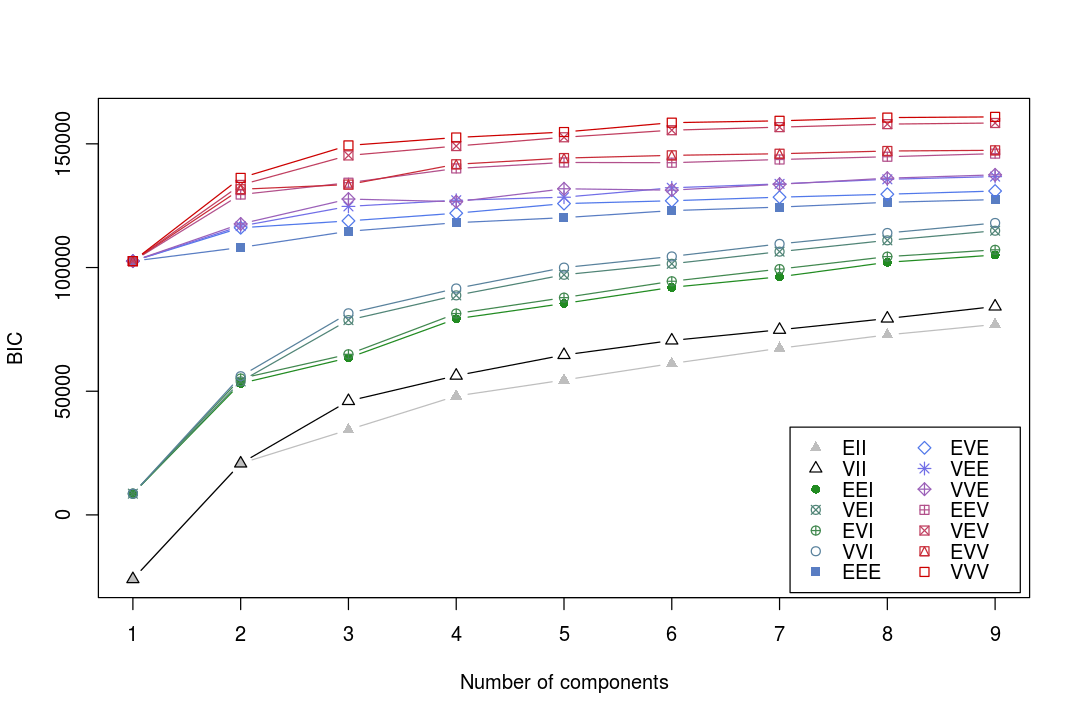

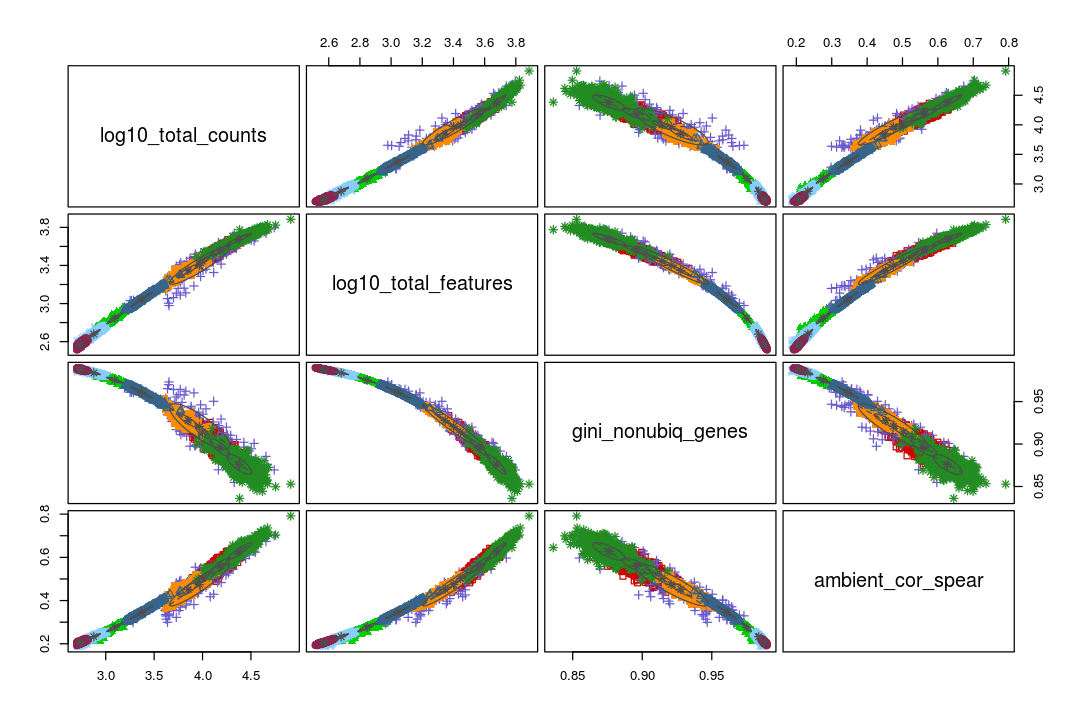

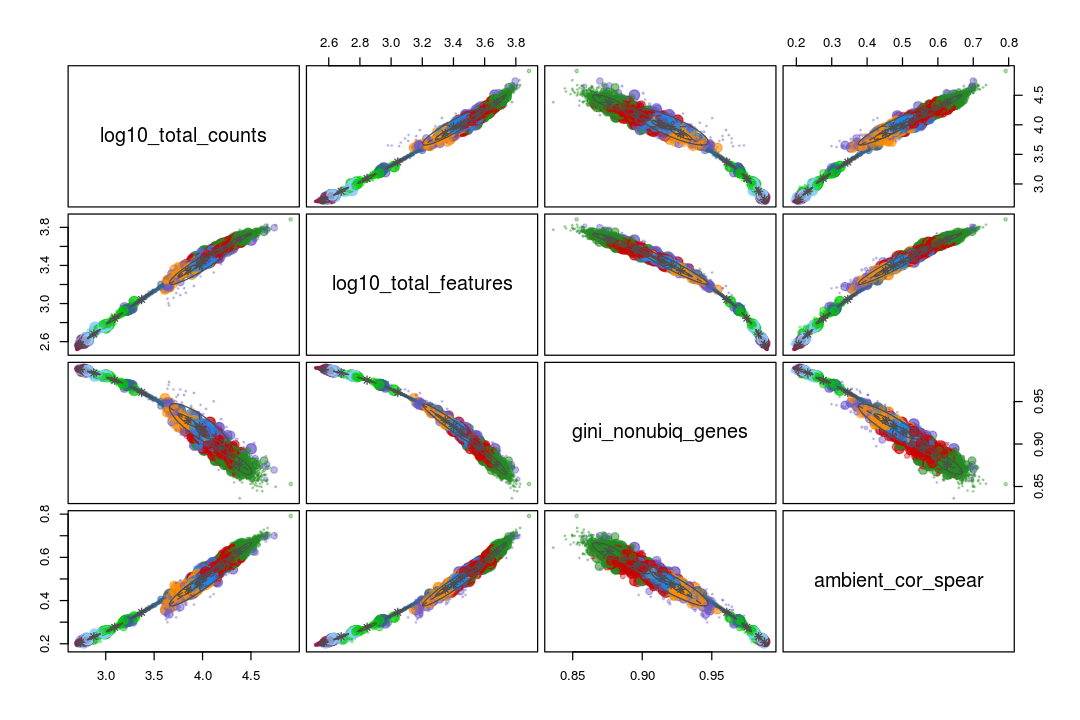

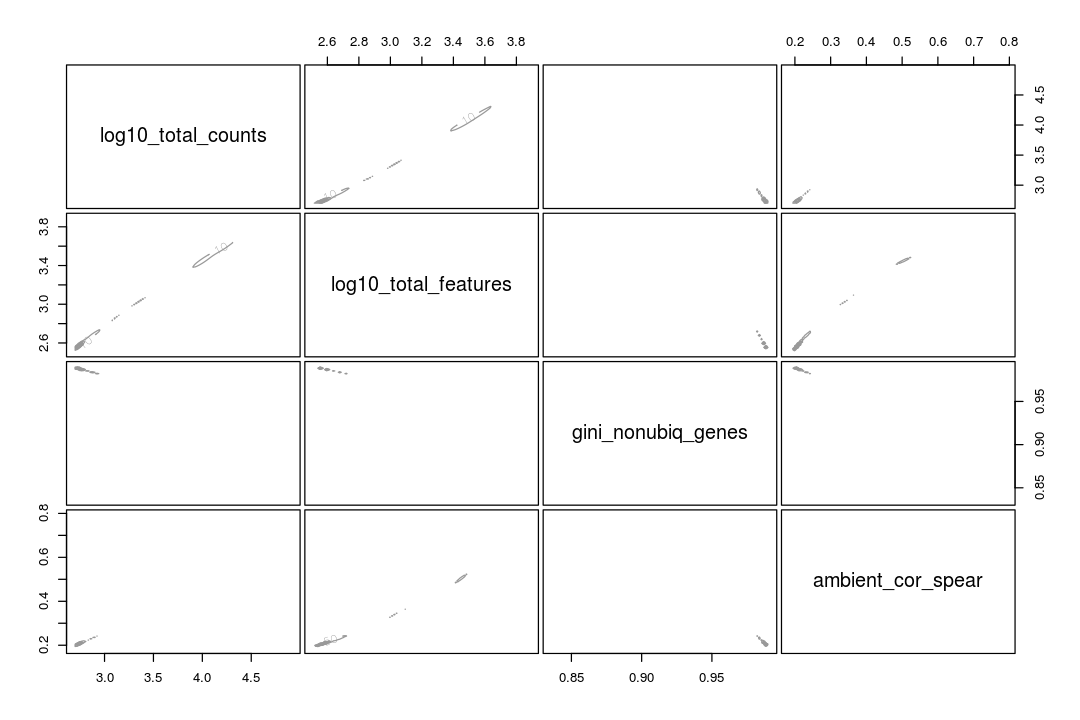

In [25]:
plot(mc2)

In [26]:
sce_train_small$mclust_4metrics_class <- as.factor(mc2$classification)

Picking joint bandwidth of 0.0284


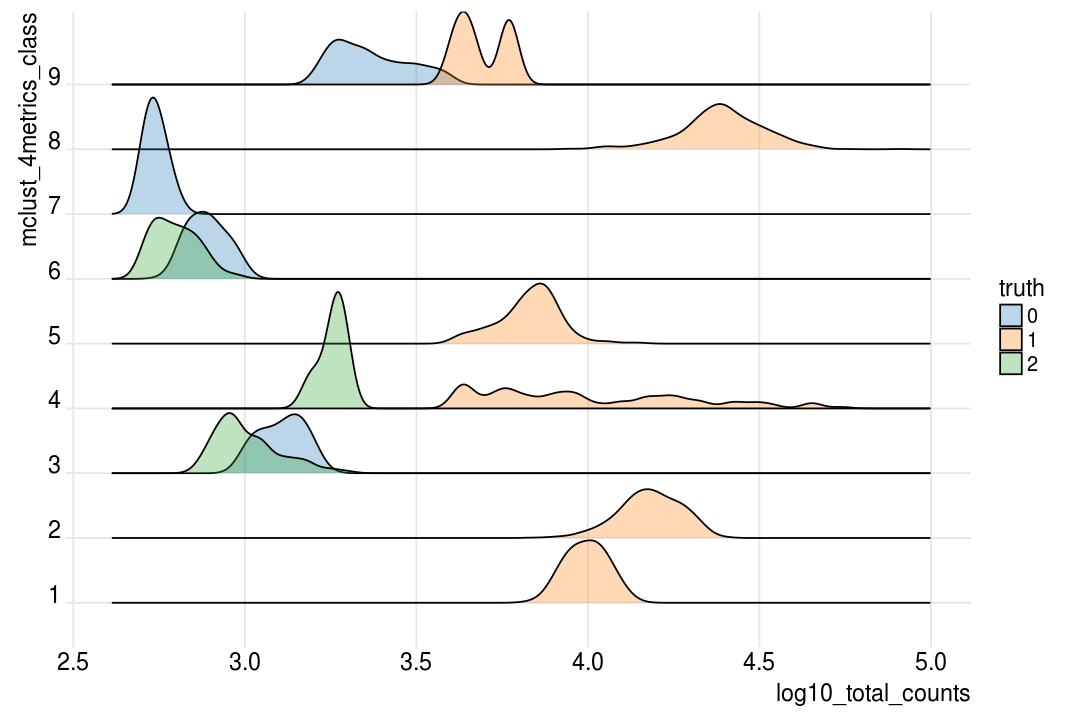

In [27]:
options(repr.plot.width = 9, repr.plot.height = 6)
ggplot(pData(sce_train_small), aes(x = log10_total_counts, y = mclust_4metrics_class, fill = truth)) +
    geom_joy(alpha = 0.3) + scale_fill_tableau() + theme_joy()

In [32]:
housekeeping_genes <- c("C1orf43", "CHMP2A", "EMC7", "GPI", "PSMB2", "PSMB4", "RAB7A", "REEP5", 
                        "SNRPD3", "VCP", "VPS29")

In [30]:
hallmark_genesets <- GSEABase::getGmt("msigdb/h.all.v6.0.symbols.gmt")

In [31]:
hallmark_genesets

GeneSetCollection
  names: HALLMARK_TNFA_SIGNALING_VIA_NFKB, HALLMARK_HYPOXIA, ..., HALLMARK_PANCREAS_BETA_CELLS (50 total)
  unique identifiers: JUNB, CXCL2, ..., SRP14 (4386 total)
  types in collection:
    geneIdType: NullIdentifier (1 total)
    collectionType: NullCollection (1 total)

In [115]:
grep("MITOC", names(hallmark_genesets))

integer(0)

In [33]:
grep("APOP", names(hallmark_genesets))

[1] 10

In [39]:
fData(sce_train_small)$gene_id <- toupper(fData(sce_train_small)$gene_id)

In [46]:
library(EnsDb.Hsapiens.v86)

In [57]:
ids <- mapIds(EnsDb.Hsapiens.v86, keys = fData(sce_train_small)$gene_id, 
              column = c("SYMBOL", "GENEID"), keytype="GENEID")

In [56]:
head(ids)

ENSG00000000003 ENSG00000000005 ENSG00000000419 ENSG00000000457 ENSG00000000460 
       "TSPAN6"          "TNMD"          "DPM1"         "SCYL3"      "C1orf112" 
ENSG00000000938 
          "FGR"

In [49]:
columns(EnsDb.Hsapiens.v86)

[1] "ENTREZID"            "EXONID"              "EXONIDX"            
 [4] "EXONSEQEND"          "EXONSEQSTART"        "GENEBIOTYPE"        
 [7] "GENEID"              "GENENAME"            "GENESEQEND"         
[10] "GENESEQSTART"        "INTERPROACCESSION"   "ISCIRCULAR"         
[13] "PROTDOMEND"          "PROTDOMSTART"        "PROTEINDOMAINID"    
[16] "PROTEINDOMAINSOURCE" "PROTEINID"           "PROTEINSEQUENCE"    
[19] "SEQCOORDSYSTEM"      "SEQLENGTH"           "SEQNAME"            
[22] "SEQSTRAND"           "SYMBOL"              "TXBIOTYPE"          
[25] "TXCDSSEQEND"         "TXCDSSEQSTART"       "TXID"               
[28] "TXNAME"              "TXSEQEND"            "TXSEQSTART"         
[31] "UNIPROTDB"           "UNIPROTID"           "UNIPROTMAPPINGTYPE"

In [58]:
fData(sce_train_small)$hgnc_symbol <- ids

In [59]:
head(fData(sce_train_small))

gene_id         mean_exprs   exprs_rank n_cells_exprs
ensg00000000003 ENSG00000000003 3.213799e-02 19084      2310         
ensg00000000005 ENSG00000000005 5.919413e-06  2559         1         
ensg00000000419 ENSG00000000419 1.283104e-01 20795      6600         
ensg00000000457 ENSG00000000457 2.657659e-03 12767       336         
ensg00000000460 ENSG00000000460 4.482624e-03 14266       337         
ensg00000000938 ENSG00000000938 1.397604e-04  6940        20         
                total_feature_exprs pct_total_exprs pct_dropout
ensg00000000003 2321.6159374        6.389728e-03    96.80228   
ensg00000000005    0.4276125        1.176908e-06    99.99862   
ensg00000000419 9269.0180316        2.551090e-02    90.86366   
ensg00000000457  191.9866574        5.284003e-04    99.53488   
ensg00000000460  323.8202681        8.912428e-04    99.53349   
ensg00000000938   10.0961532        2.778740e-05    99.97231   
                total_feature_counts log10_total_feature_counts
ensg00000000003 2838                 3.453165                  
ensg00000000005    1                 0.301030                  
ensg00000000419 9508                 3.978135                  
ensg00000000457  359                 2.556303                  
ensg00000000460  354                 2.550228                  
ensg00000000938   20                 1.322219                  
                pct_total_counts is_feature_control ensembl_transcript_id
ensg00000000003 4.194154e-03     FALSE              NA                   
ensg00000000005 1.477855e-06     FALSE              NA                   
ensg00000000419 1.405145e-02     FALSE              NA                   
ensg00000000457 5.305501e-04     FALSE              NA                   
ensg00000000460 5.231608e-04     FALSE              NA                   
ensg00000000938 2.955711e-05     FALSE              NA                   
                ensembl_gene_id hgnc_symbol chromosome_name feature_symbol 
ensg00000000003 NA              TSPAN6      NA              ensg00000000003
ensg00000000005 NA              TNMD        NA              ensg00000000005
ensg00000000419 NA              DPM1        NA              ensg00000000419
ensg00000000457 NA              SCYL3       NA              ensg00000000457
ensg00000000460 NA              C1orf112    NA              ensg00000000460
ensg00000000938 NA              FGR         NA              ensg00000000938

In [60]:
get_geneset_score <- function(object, geneset) {
    set_total <- colSums(counts(object)[fData(object)$hgnc_symbol %in% geneset,])
    set_total / object$total_counts
}

In [72]:
add_geneset_scores <- function(object, geneset_list) {
    for (i in seq_along(geneset_list))
        pData(object)[, names(geneset_list)[i]] <- get_geneset_score(object, geneset_list[[1]]@geneIds)
    object
}

In [69]:
sce_train_small$housekeeping_score <- get_geneset_score(sce_train_small, housekeeping_genes)

In [73]:
sce_train_small <- add_geneset_scores(sce_train_small, genesets)

In [83]:
sce_train_small <- add_geneset_scores(sce_train_small, hallmark_genesets)

In [84]:
varLabels(sce_train_small)

[1] "barcode"                                              
 [2] "truth"                                                
 [3] "total_counts"                                         
 [4] "log10_total_counts"                                   
 [5] "filter_on_total_counts"                               
 [6] "total_features"                                       
 [7] "log10_total_features"                                 
 [8] "filter_on_total_features"                             
 [9] "pct_dropout"                                          
[10] "n_detected_feature_controls"                          
[11] "counts_feature_controls"                              
[12] "pct_counts_feature_controls"                          
[13] "filter_on_pct_counts_feature_controls"                
[14] "pct_counts_top_50_features"                           
[15] "pct_counts_top_100_features"                          
[16] "pct_counts_top_200_features"                          
[17] "pct_counts_top_500_features"                          
[18] "pct_counts_top_50_endogenous_features"                
[19] "pct_counts_top_100_endogenous_features"               
[20] "pct_counts_top_200_endogenous_features"               
[21] "pct_counts_top_500_endogenous_features"               
[22] "counts_endogenous_features"                           
[23] "log10_counts_feature_controls"                        
[24] "log10_counts_endogenous_features"                     
[25] "is_cell_control"                                      
[26] "gini_all_genes"                                       
[27] "gini_ubiq_genes"                                      
[28] "gini_nonubiq_genes"                                   
[29] "mclust_umis_class"                                    
[30] "ambient_cor_spear"                                    
[31] "mclust_4metrics_class"                                
[32] "housekeeping_score"                                   
[33] "REACTOME_EXTRINSIC_PATHWAY_FOR_APOPTOSIS"             
[34] "REACTOME_APOPTOTIC_CLEAVAGE_OF_CELLULAR_PROTEINS"     
[35] "REACTOME_APOPTOSIS_INDUCED_DNA_FRAGMENTATION"         
[36] "REACTOME_APOPTOTIC_CLEAVAGE_OF_CELL_ADHESION_PROTEINS"
[37] "REACTOME_REGULATION_OF_APOPTOSIS"                     
[38] "REACTOME_ROLE_OF_DCC_IN_REGULATING_APOPTOSIS"         
[39] "REACTOME_APOPTOSIS"                                   
[40] "REACTOME_INTRINSIC_PATHWAY_FOR_APOPTOSIS"             
[41] "REACTOME_APOPTOTIC_EXECUTION_PHASE"                   
[42] "HALLMARK_TNFA_SIGNALING_VIA_NFKB"                     
[43] "HALLMARK_HYPOXIA"                                     
[44] "HALLMARK_CHOLESTEROL_HOMEOSTASIS"                     
[45] "HALLMARK_MITOTIC_SPINDLE"                             
[46] "HALLMARK_WNT_BETA_CATENIN_SIGNALING"                  
[47] "HALLMARK_TGF_BETA_SIGNALING"                          
[48] "HALLMARK_IL6_JAK_STAT3_SIGNALING"                     
[49] "HALLMARK_DNA_REPAIR"                                  
[50] "HALLMARK_G2M_CHECKPOINT"                              
[51] "HALLMARK_APOPTOSIS"                                   
[52] "HALLMARK_NOTCH_SIGNALING"                             
[53] "HALLMARK_ADIPOGENESIS"                                
[54] "HALLMARK_ESTROGEN_RESPONSE_EARLY"                     
[55] "HALLMARK_ESTROGEN_RESPONSE_LATE"                      
[56] "HALLMARK_ANDROGEN_RESPONSE"                           
[57] "HALLMARK_MYOGENESIS"                                  
[58] "HALLMARK_PROTEIN_SECRETION"                           
[59] "HALLMARK_INTERFERON_ALPHA_RESPONSE"                   
[60] "HALLMARK_INTERFERON_GAMMA_RESPONSE"                   
[61] "HALLMARK_APICAL_JUNCTION"                             
[62] "HALLMARK_APICAL_SURFACE"                              
[63] "HALLMARK_HEDGEHOG_SIGNALING"                          
[64] "HALLMARK_COMPLEMENT"                                  
[65] "HALLMARK_UNFOLDED_PROTEIN_RESPONSE"                   
[66] "HALLMARK_PI3K_AKT_MTOR_SIGNALI

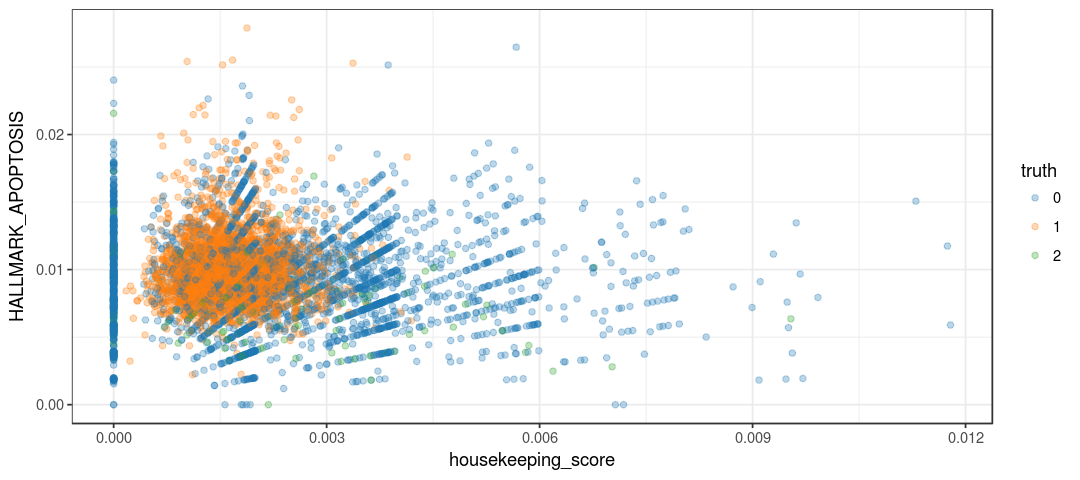

In [87]:
options(repr.plot.width=9, repr.plot.height=4)
ggplot(pData(sce_train_small), aes(x = housekeeping_score, y = HALLMARK_APOPTOSIS, colour = truth)) +
    geom_point(alpha = 0.3) + scale_color_tableau() + theme_bw()

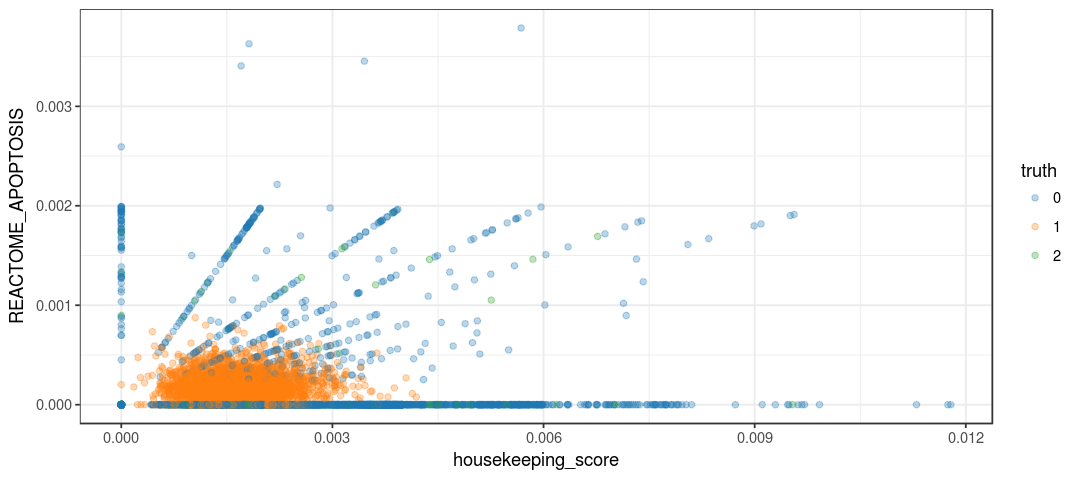

In [77]:
options(repr.plot.width=9, repr.plot.height=4)
ggplot(pData(sce_train_small), aes(x = housekeeping_score, y = REACTOME_APOPTOSIS, colour = truth)) +
    geom_point(alpha = 0.3) + scale_color_tableau() + theme_bw()

Picking joint bandwidth of 0.000296


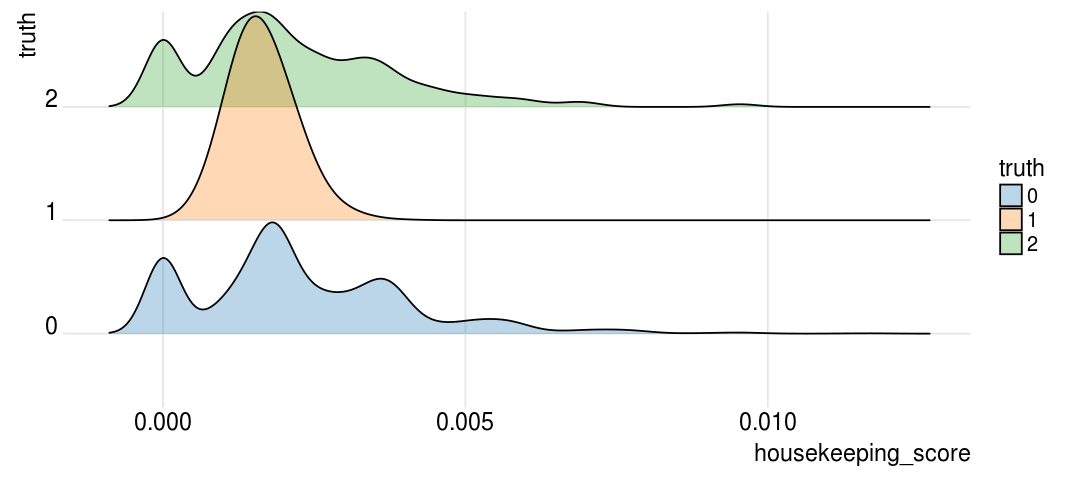

In [81]:
options(repr.plot.width=9, repr.plot.height=4)
ggplot(pData(sce_train_small), aes(x = housekeeping_score, y = truth, fill = truth)) +
    geom_joy(alpha = 0.3) + scale_fill_tableau() + theme_joy()

Picking joint bandwidth of 8.27e-05


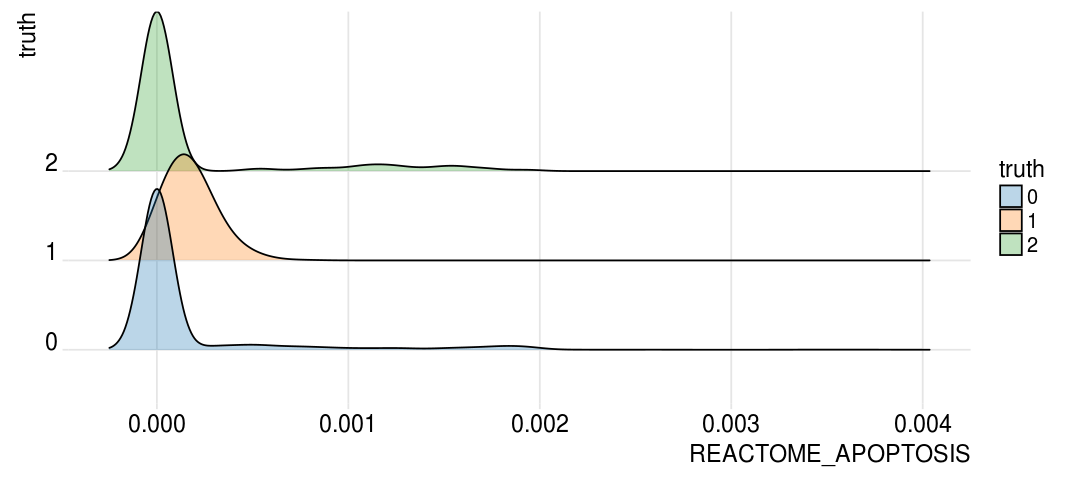

In [82]:
options(repr.plot.width=9, repr.plot.height=4)
ggplot(pData(sce_train_small), aes(x = REACTOME_APOPTOSIS, y = truth, fill = truth)) +
    geom_joy(alpha = 0.3) + scale_fill_tableau() + theme_joy()

Picking joint bandwidth of 0.000622


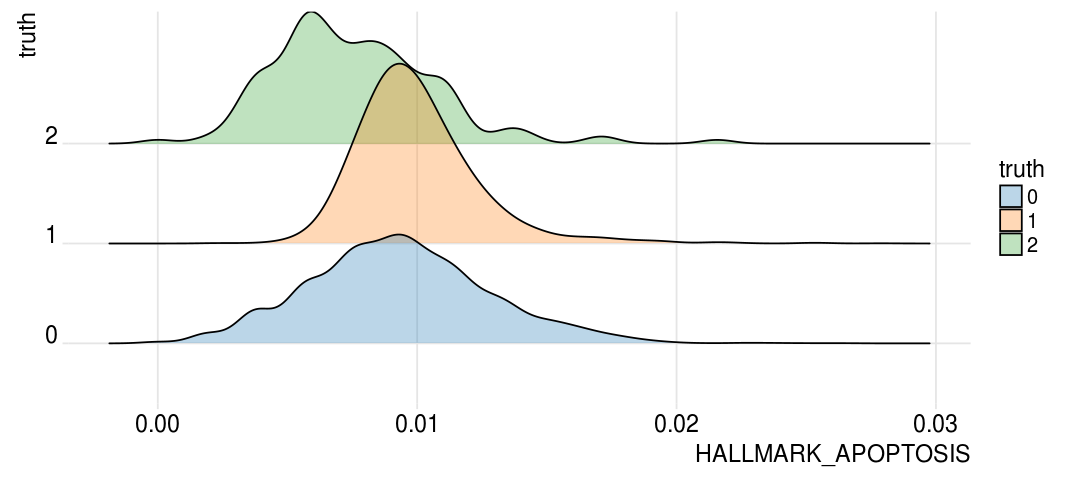

In [88]:
options(repr.plot.width=9, repr.plot.height=4)
ggplot(pData(sce_train_small), aes(x = HALLMARK_APOPTOSIS, y = truth, fill = truth)) +
    geom_joy(alpha = 0.3) + scale_fill_tableau() + theme_joy()

In [95]:
mc3 <- Mclust(pData(sce_train_small)[, c("log10_total_counts", "log10_total_features", 
                                         "gini_nonubiq_genes", "ambient_cor_spear", "housekeeping_score",
                                        "HALLMARK_APOPTOSIS")])

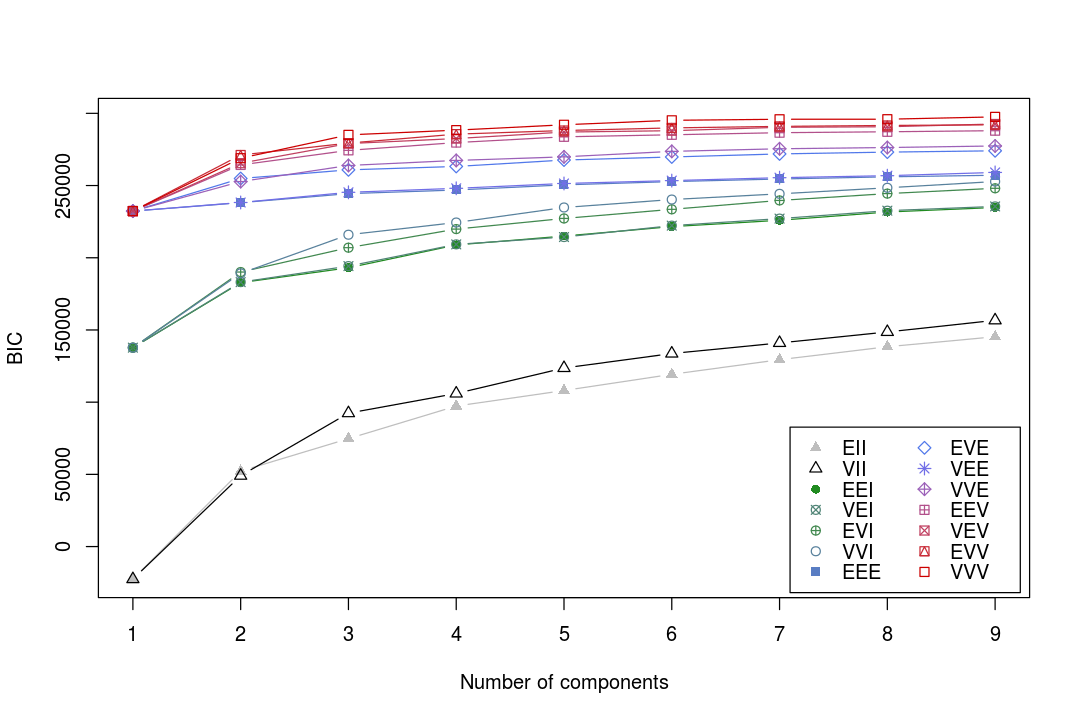

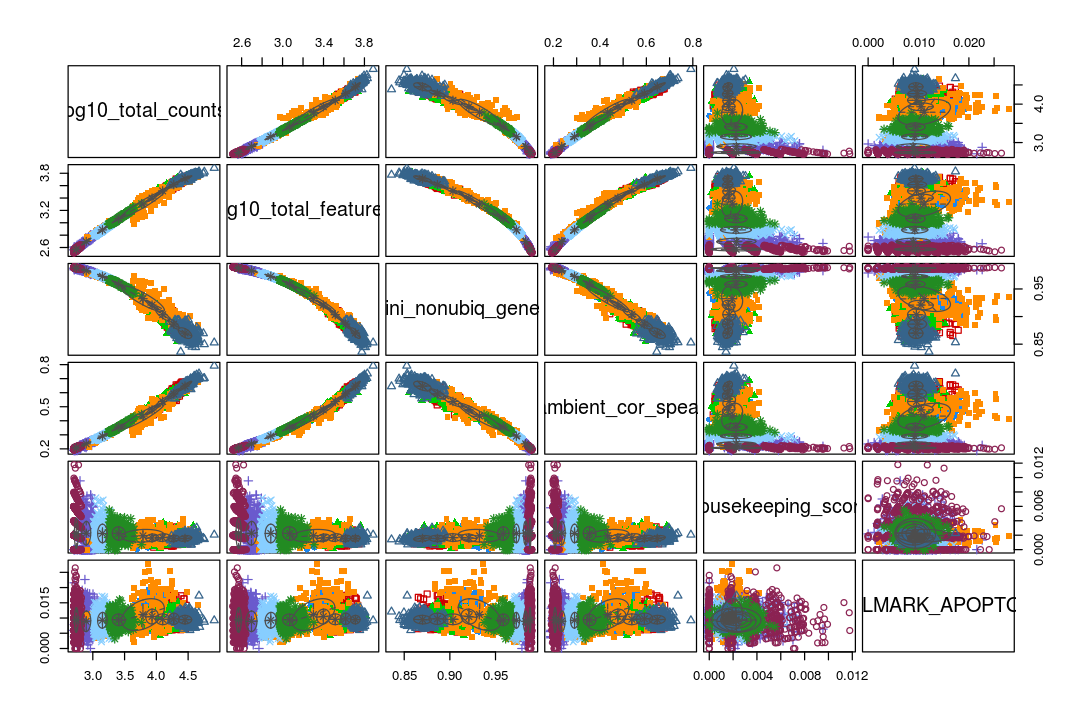

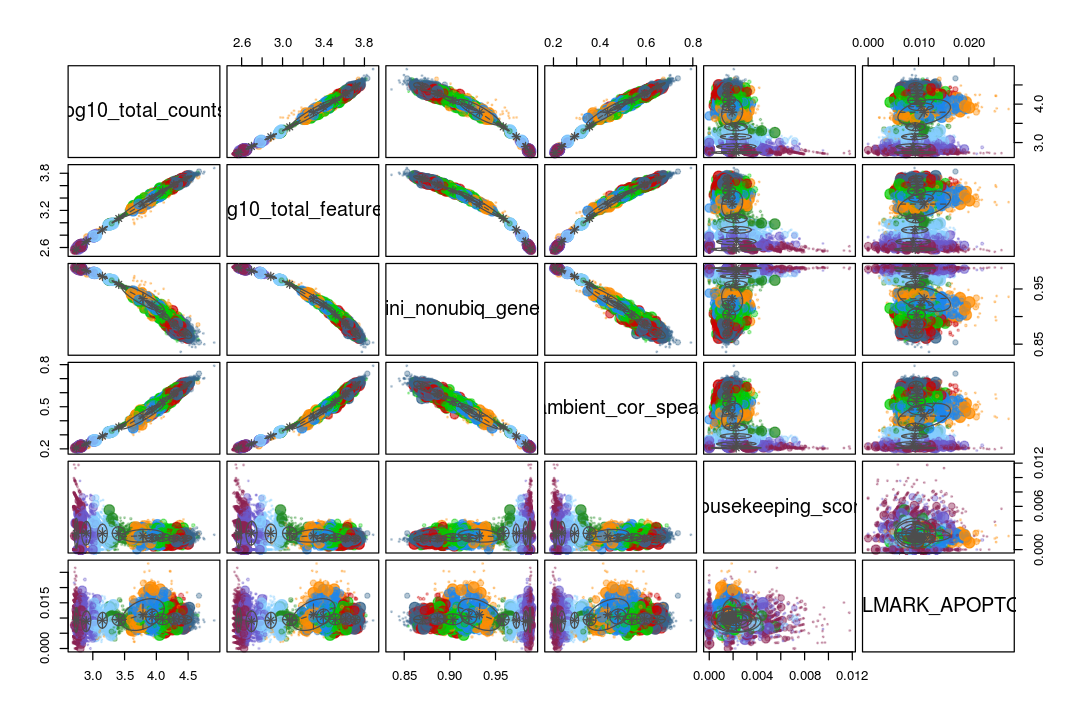

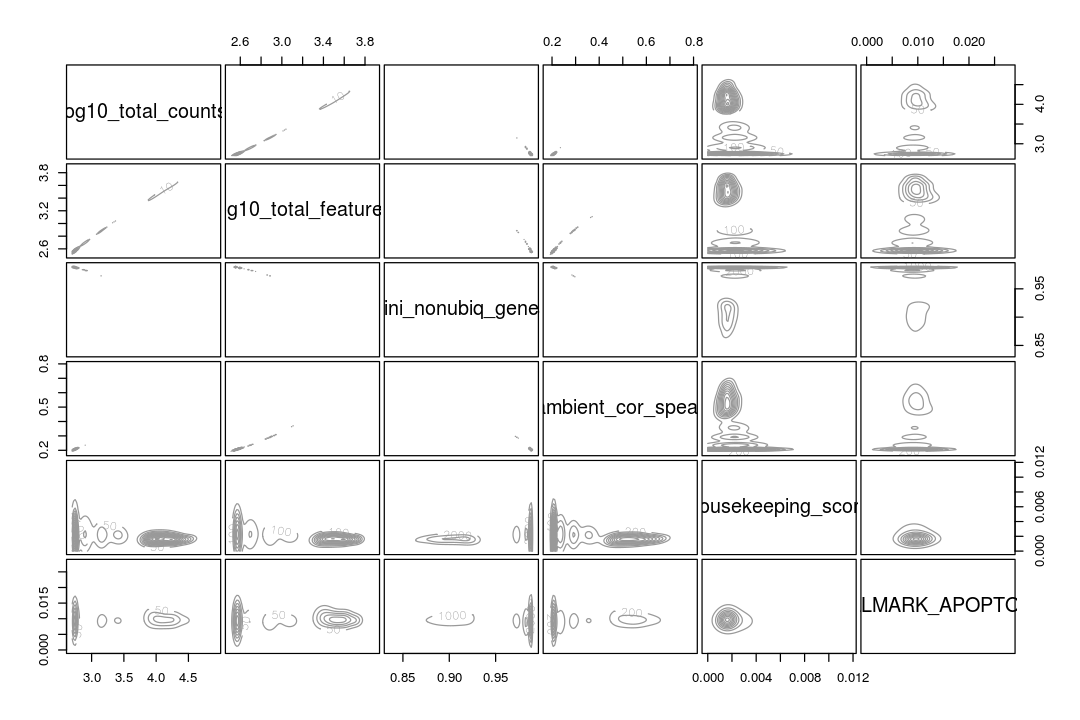

In [96]:
plot(mc3)

In [97]:
sce_train_small$mclust_genesetmetrics_class <- as.factor(mc3$classification)

Picking joint bandwidth of 0.0256


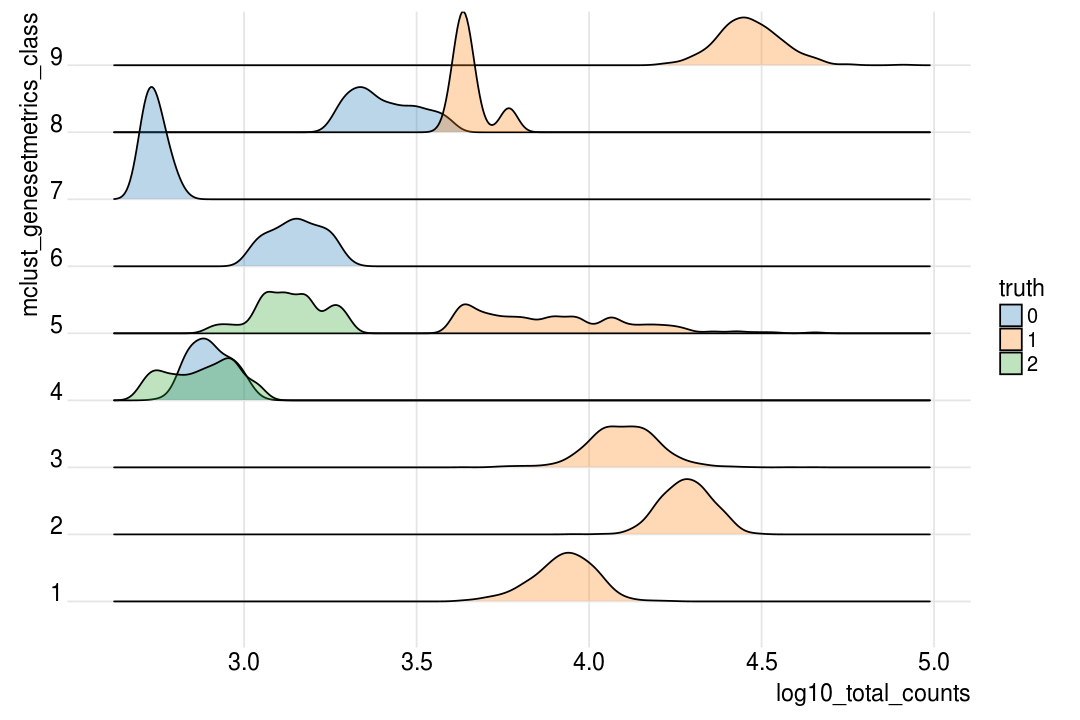

In [98]:
options(repr.plot.width = 9, repr.plot.height = 6)
ggplot(pData(sce_train_small), aes(x = log10_total_counts, y = mclust_genesetmetrics_class, fill = truth)) +
    geom_joy(alpha = 0.3) + scale_fill_tableau() + theme_joy()

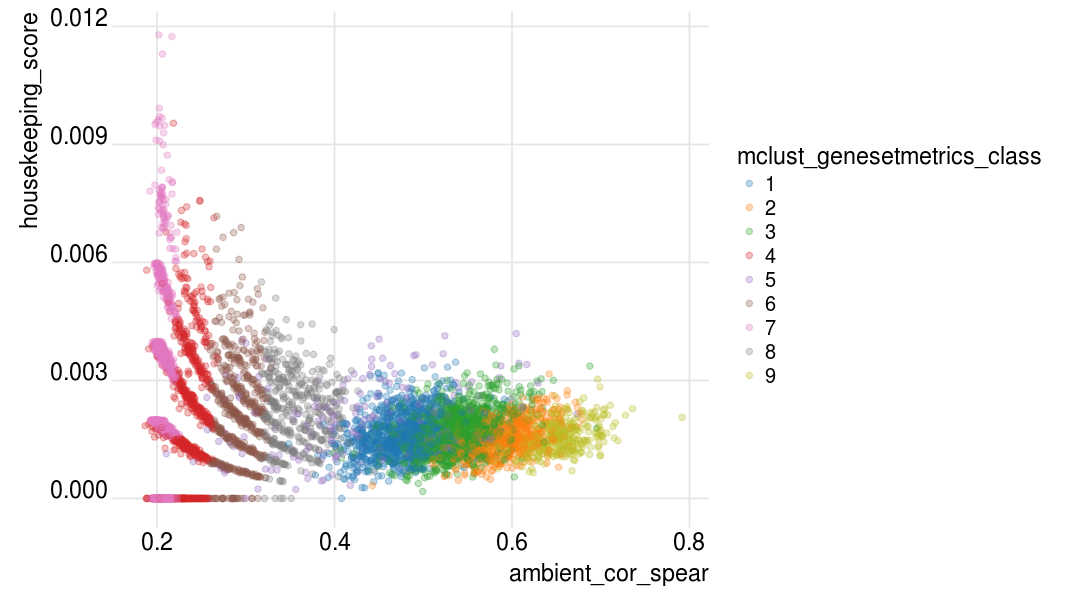

In [106]:
options(repr.plot.width = 9, repr.plot.height = 5)
ggplot(pData(sce_train_small), aes(x = ambient_cor_spear, y = housekeeping_score, 
                                   colour = mclust_genesetmetrics_class)) +
    geom_point(alpha = 0.3) + scale_color_tableau() + theme_joy()

Picking joint bandwidth of 0.0075


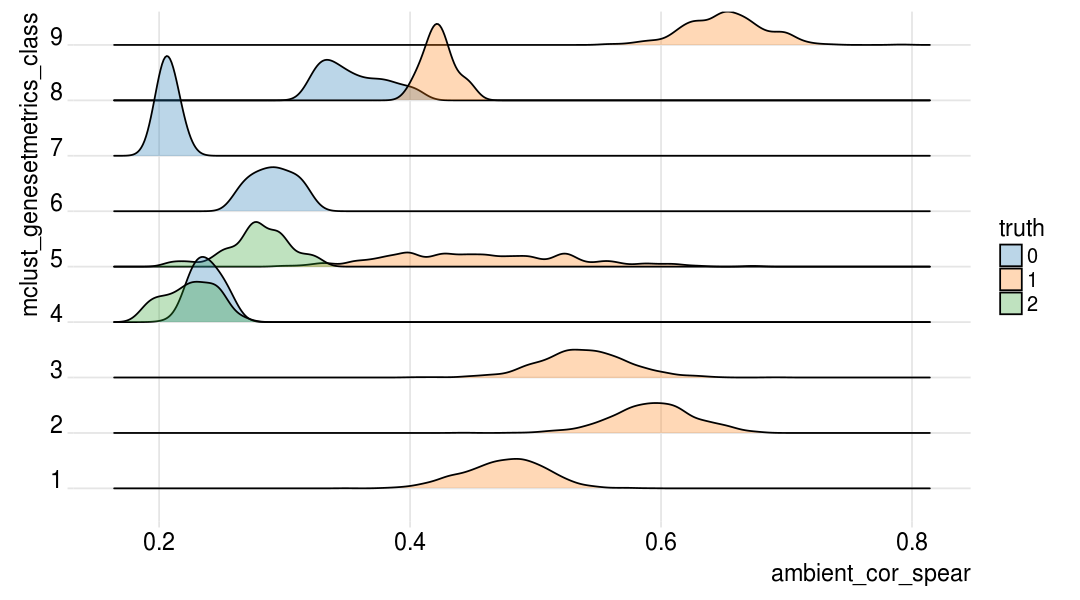

In [108]:
options(repr.plot.width = 9, repr.plot.height = 5)
ggplot(pData(sce_train_small), aes(x = ambient_cor_spear, y = mclust_genesetmetrics_class, 
                                   fill = truth)) +
    geom_joy(alpha = 0.3) + scale_fill_tableau() + theme_joy()

Picking joint bandwidth of 0.000308


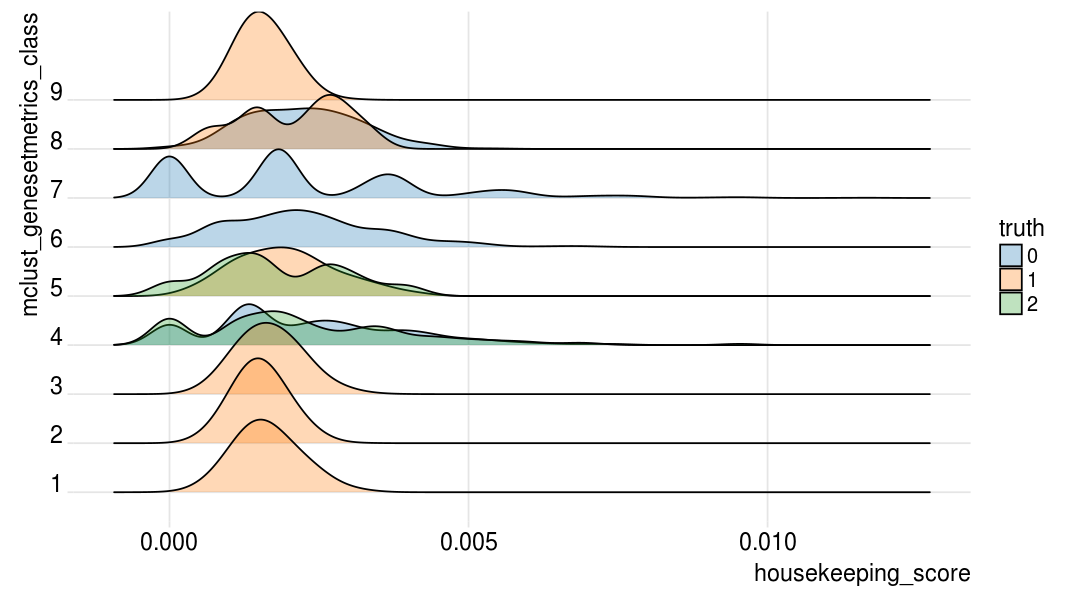

In [109]:
options(repr.plot.width = 9, repr.plot.height = 5)
ggplot(pData(sce_train_small), aes(x = housekeeping_score, y = mclust_genesetmetrics_class, 
                                   fill = truth)) +
    geom_joy(alpha = 0.3) + scale_fill_tableau() + theme_joy()

Picking joint bandwidth of 0.00071


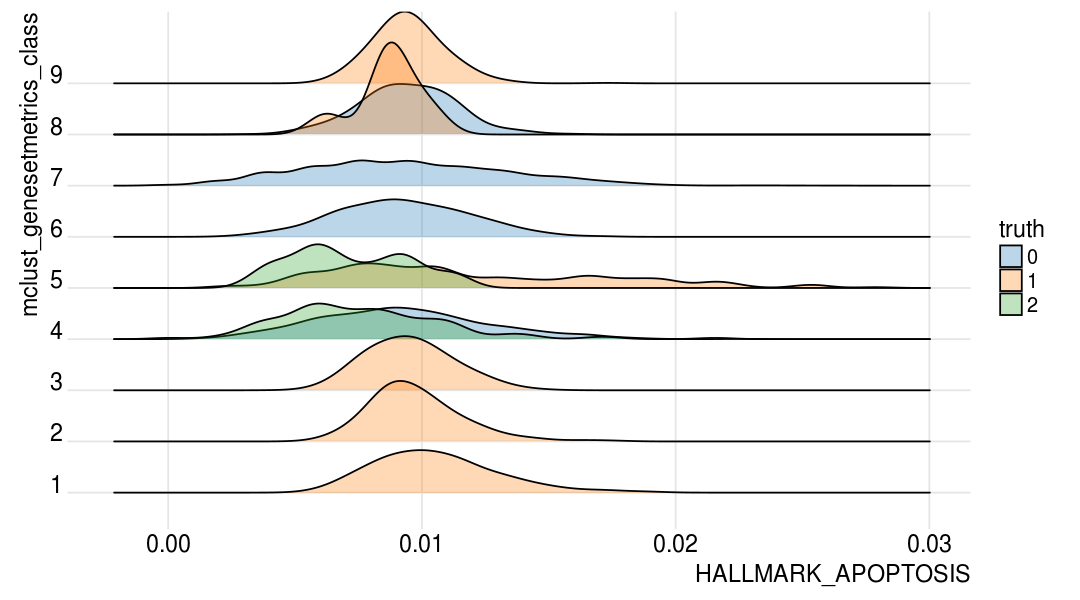

In [111]:
options(repr.plot.width = 9, repr.plot.height = 5)
ggplot(pData(sce_train_small), aes(x = HALLMARK_APOPTOSIS, y = mclust_genesetmetrics_class, 
                                   fill = truth)) +
    geom_joy(alpha = 0.3) + scale_fill_tableau() + theme_joy()

Picking joint bandwidth of 0.00071


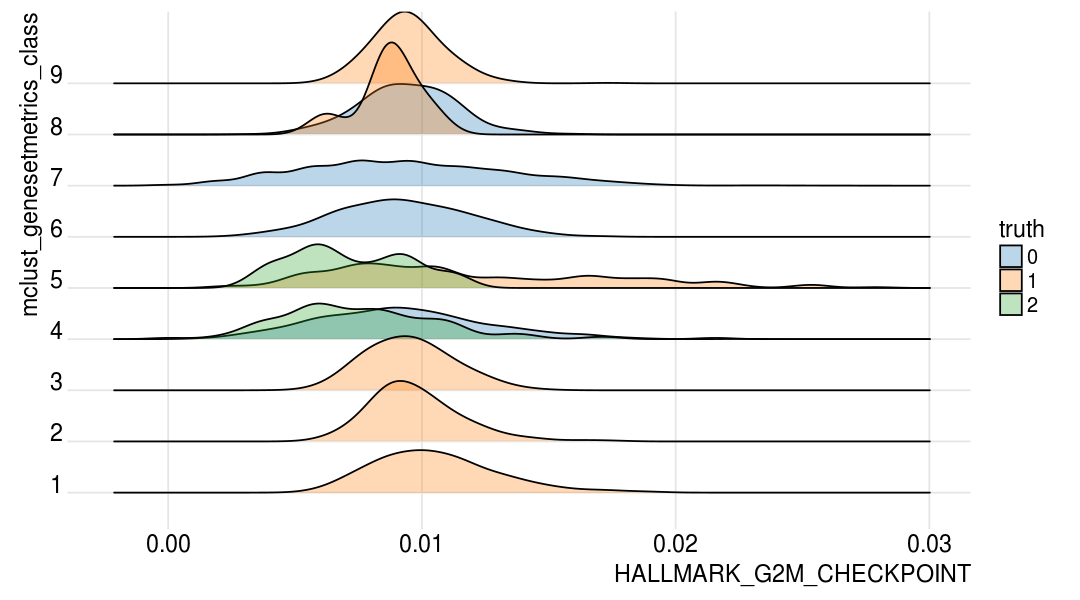

In [112]:
options(repr.plot.width = 9, repr.plot.height = 5)
ggplot(pData(sce_train_small), aes(x = HALLMARK_G2M_CHECKPOINT, y = mclust_genesetmetrics_class, 
                                   fill = truth)) +
    geom_joy(alpha = 0.3) + scale_fill_tableau() + theme_joy()

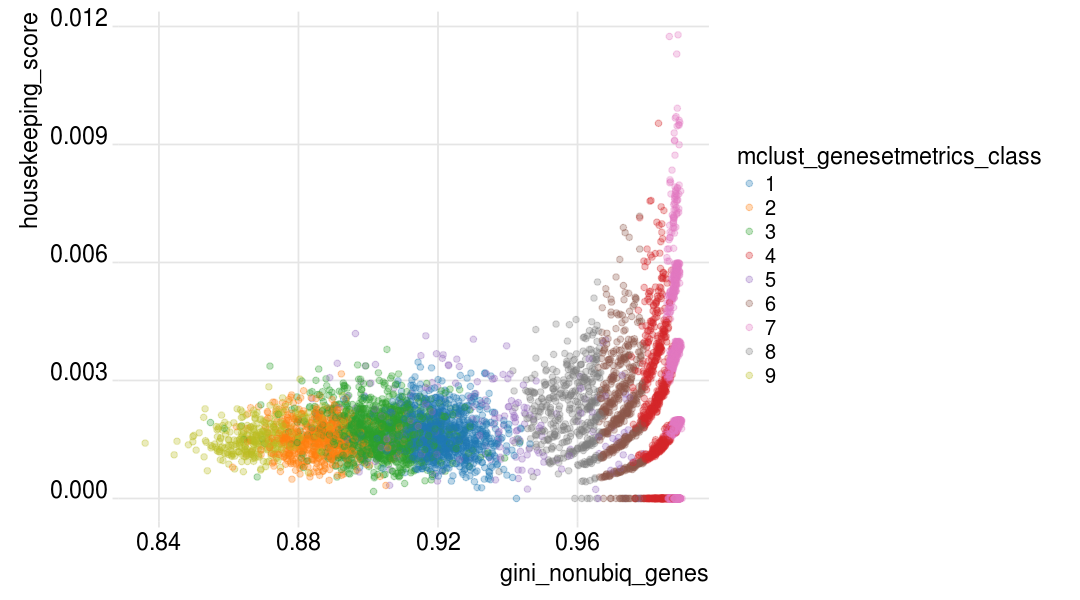

In [107]:
options(repr.plot.width = 9, repr.plot.height = 5)
ggplot(pData(sce_train_small), aes(x = gini_nonubiq_genes, y = housekeeping_score, 
                                   colour = mclust_genesetmetrics_class)) +
    geom_point(alpha = 0.3) + scale_color_tableau() + theme_joy()

In [95]:
mc3 <- Mclust(pData(sce_train_small)[, c("log10_total_counts", "log10_total_features", 
                                         "gini_nonubiq_genes", "ambient_cor_spear", "housekeeping_score",
                                        "HALLMARK_APOPTOSIS")])